In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from statsmodels.stats.anova import AnovaRM


In [2]:
df = pd.read_csv('pilot5_shuffled_nonresp_inc_ltm.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns


In [3]:
def remove_unit_variance(df, col, unit, group=None, suffix="_within"):
    """Remove variance between sampling units.

    This is useful for plotting repeated-measures data using within-unit
    error bars.

    Parameters
    ----------
    df : DataFrame
        Input data. Will have a new column added.
    col : column name
        Column in dataframe with quantitative measure to modify.
    unit : column name
        Column in dataframe defining sampling units (e.g., subjects).
    group : column name(s), optional
        Columns defining groups to remove unit variance within.
    suffix : string, optional
        Suffix appended to ``col`` name to create new column.

    Returns
    -------
    df : DataFrame
        Returns modified dataframe.

    """
    new_col = col + suffix

    def demean(x):
        return x - x.mean()

    if group is None:
        new = df.groupby(unit)[col].transform(demean)
        new += df[col].mean()
        df.loc[:, new_col] = new
    else:
        df.loc[:, new_col] = np.nan
        for level, df_level in df.groupby(group):
            new = df_level.groupby(unit)[col].transform(demean)
            new += df_level[col].mean()
            df.loc[new.index, new_col] = new

    return df

In [4]:
df = remove_unit_variance(df,'mouse.time_last','participant')
df['analysis_rt'] = df['mouse.time_last_within']

In [5]:
palette = sns.color_palette("husl", n_colors=2)[::-1]  # Reverse the color order


In [6]:
# df['IT Distractor Similarity\nto Prioritized Item']

In [7]:
df['Distractor V2 Similarity Preference'] = df['v2_prefers'] 
df['Distractor IT Similarity Preference'] = df['it_prefers']


column_params = {
    'v2': {'n_cats': 5, 'labels': ['Least Similar', 'Less Similar', 'Neutral', 'More Similar', 'Most Similar']},
    'it': {'n_cats': 5, 'labels': ['Least Similar', 'Less Similar', 'Neutral', 'More Similar', 'Most Similar']}
}

for label in ['it_sim_dis_attend', 'v2_sim_dis_attend', 'it_sim_dis_unattend', 'v2_sim_dis_unattend', 'it_sim_dis_diff', 'v2_sim_dis_diff','v2_sim_dis_diff_sq', 'it_sim_dis_diff_sq']:
    
    if 'v2' in label:
        n_cats = column_params['v2']['n_cats']
        labels = column_params['v2']['labels']
    else:
        n_cats = column_params['it']['n_cats']
        labels = column_params['it']['labels']
    
    df[label + '_cat'] = pd.qcut(df[label], q=n_cats, labels=labels, duplicates='drop')


df['V2 Distractor Similarity\nto Prioritized Item'] = df['v2_sim_dis_attend_cat']
df['IT Distractor Similarity\nto Prioritized Item'] = df['it_sim_dis_attend_cat']
df['V2 Distractor Similarity\nto Deprioritized Item'] = df['v2_sim_dis_unattend_cat']
df['IT Distractor Similarity\nto Deprioritized Item'] = df['it_sim_dis_unattend_cat']
df['Prioritized - Deprioritized IT Distractor Similarity'] = df['it_sim_dis_diff_cat'] 
df['Prioritized - Deprioritized V2 Distractor Similarity'] = df['v2_sim_dis_diff_cat'] 
df['Prioritized - Deprioritized IT Distractor Similarity Squared'] = df['v2_sim_dis_diff_sq_cat'] 
df['Prioritized - Deprioritized V2 Distractor Similarity Squared'] = df['it_sim_dis_diff_sq_cat'] 


In [8]:
df['IT Distractor Similarity\nto Deprioritized Item']

0         Less Similar
1         Less Similar
2         More Similar
3         Less Similar
4        Least Similar
             ...      
40195     More Similar
40196     More Similar
40197     Most Similar
40198     Less Similar
40199          Neutral
Name: IT Distractor Similarity\nto Deprioritized Item, Length: 40200, dtype: category
Categories (5, object): ['Least Similar' < 'Less Similar' < 'Neutral' < 'More Similar' < 'Most Similar']

In [9]:
df['it_sim_dis_diff'] = df['it_sim_dis_diff'] - np.mean(df['it_sim_dis_diff'])
df['v2_sim_dis_diff'] = df['v2_sim_dis_diff'] - np.mean(df['v2_sim_dis_diff'])

df['it_sim_dis_diff_sq'] = [x**2 for x in df['it_sim_dis_diff']]
df['v2_sim_dis_diff_sq'] = [x**2 for x in df['v2_sim_dis_diff']]

df['it_sim_dis_diff_sq'] = df['it_sim_dis_diff_sq'] - np.mean(df['it_sim_dis_diff_sq'])
df['v2_sim_dis_diff_sq'] = df['v2_sim_dis_diff_sq'] - np.mean(df['v2_sim_dis_diff_sq'])


df['IT_diff_binned'] = pd.qcut(df['it_sim_dis_diff'], 5, duplicates='drop')
df['V2_diff_binned'] = pd.qcut(df['v2_sim_dis_diff'], 5, duplicates='drop')
df['IT_diff_binned_sq'] = pd.qcut(df['it_sim_dis_diff_sq'], 5, duplicates='drop')
df['V2_diff_binned_sq'] = pd.qcut(df['v2_sim_dis_diff_sq'], 5, duplicates='drop')

def round_to_significant_figures(x, sig_figs=2):
    if x == 0:
        return 0
    else:
        return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)


def process_interval(interval):
    # Round both bounds
    lower_rounded = round_to_significant_figures(interval.left)
    upper_rounded = round_to_significant_figures(interval.right)
    # Return a new interval with the rounded bounds
    return pd.Interval(lower_rounded, upper_rounded)

df['IT_diff_binned'] = df['IT_diff_binned'].apply(process_interval)
df['V2_diff_binned'] = df['V2_diff_binned'].apply(process_interval)
df['IT_diff_binned_sq'] = df['IT_diff_binned_sq'].apply(process_interval)
df['V2_diff_binned_sq'] = df['V2_diff_binned_sq'].apply(process_interval)

df['Prioritized - Deprioritized V2 Distractor Similarity Ranges'] = df['V2_diff_binned']
df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['IT_diff_binned']
df['Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges'] = df['V2_diff_binned_sq']
df['Prioritized - Deprioritized IT Distractor Similarity Squared Ranges'] = df['IT_diff_binned_sq']

In [10]:
df_correct = df[df['resp_correct'] == 1]


In [11]:
df

setup_js.started  setup_js.stopped  participant  \
0                   NaN               NaN       116851   
1                   NaN               NaN       116851   
2                   NaN               NaN       116851   
3                   NaN               NaN       116851   
4                   NaN               NaN       116851   
...                 ...               ...          ...   
40195               NaN               NaN       167080   
40196               NaN               NaN       167080   
40197               NaN               NaN       167080   
40198               NaN               NaN       167080   
40199               NaN               NaN       167080   

                          date     expName psychopyVersion        OS  \
0      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
1      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
2      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
3      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
4      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
...                        ...         ...             ...       ...   
40195  2024-10-28 17:42:43.597  WM_Deepgen        2023.2.1  MacIntel   
40196  2024-10-28 17:42:43.597  WM_Deepgen        2023.2.1  MacIntel   
40197  2024-10-28 17:42:43.597  WM_Deepgen        2023.2.1  MacIntel   
40198  2024-10-28 17:42:43.597  WM_Deepgen        2023.2.1  MacIntel   
40199  2024-10-28 17:42:43.597  WM_Deepgen        2023.2.1  MacIntel   

       frameRate  Instructions1.started  Instructions1.stopped  ...  \
0       59.52381                    NaN                    NaN  ...   
1       59.52381                    NaN                    NaN  ...   
2       59.52381                    NaN                    NaN  ...   
3       59.52381                    NaN                    NaN  ...   
4       59.52381                    NaN                    NaN  ...   
...          ...                    ...                    ...  ...   
40195   62.50000                    NaN                    NaN  ...   
40196   62.50000                    NaN                    NaN  ...   
40197   62.50000                    NaN                    NaN  ...   
40198   62.50000                    NaN                    NaN  ...   
40199   62.50000                    NaN                    NaN  ...   

       v2_sim_dis_diff_sq_cat  it_sim_dis_diff_sq_cat  \
0                More Similar           Least Similar   
1               Least Similar           Least Similar   
2                Less Similar                 Neutral   
3                Less Similar            Most Similar   
4                Most Similar                 Neutral   
...                       ...                     ...   
40195           Least Similar                 Neutral   
40196            Less Similar           Least Similar   
40197            More Similar            More Similar   
40198            More Similar            Less Similar   
40199            Less Similar            Less Similar   

       Prioritized - Deprioritized IT Distractor Similarity Squared  \
0                                           More Similar              
1                                          Least Similar              
2                                           Less Similar              
3                                           Less Similar              
4                                           Most Similar              
...                                                  ...              
40195                                      Least Similar              
40196                                       Less Similar              
40197                                       More Similar              
40198                                       More Similar              
40199                                       Less Similar              

       Prioritized - Deprioritized V2 Distractor Simil

<Figure size 1000x600 with 0 Axes>

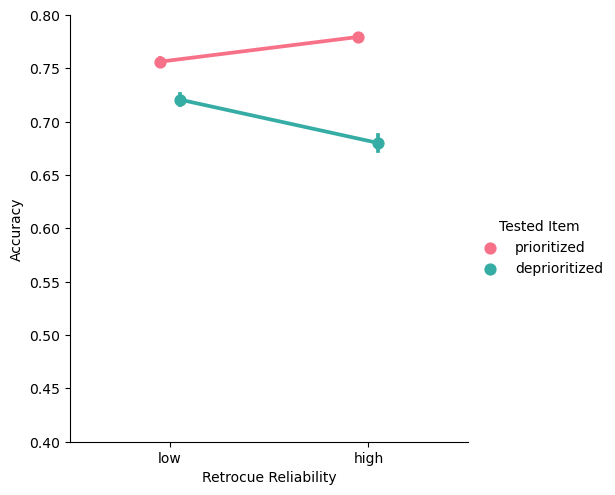

In [12]:

plt.figure(figsize=(10, 6))
sns.catplot(
    x='Retrocue Reliability',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    order = ['low','high'],
#     col = 'participant',
    kind = 'point',
    hue='Tested Item',
    dodge=0.1,
    palette=palette[::-1],  # Use the single-color palette
    data=df
)
plt.ylim(0.4, 0.8)
plt.ylabel('Accuracy')
# plt.xlabel('V2 Distractor Similarity to Prioritized Item')
# plt.title('Accuracy by V2 Distractor Similarity')
plt.show()


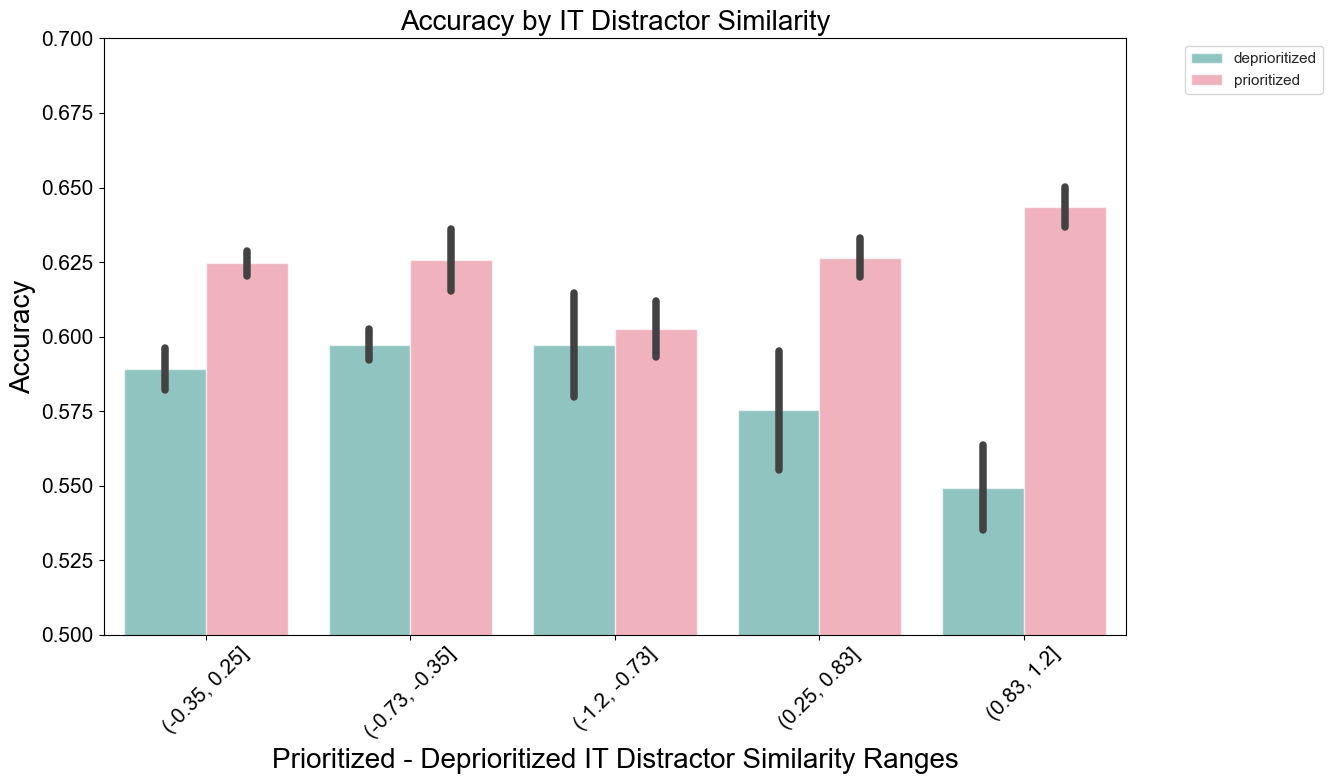

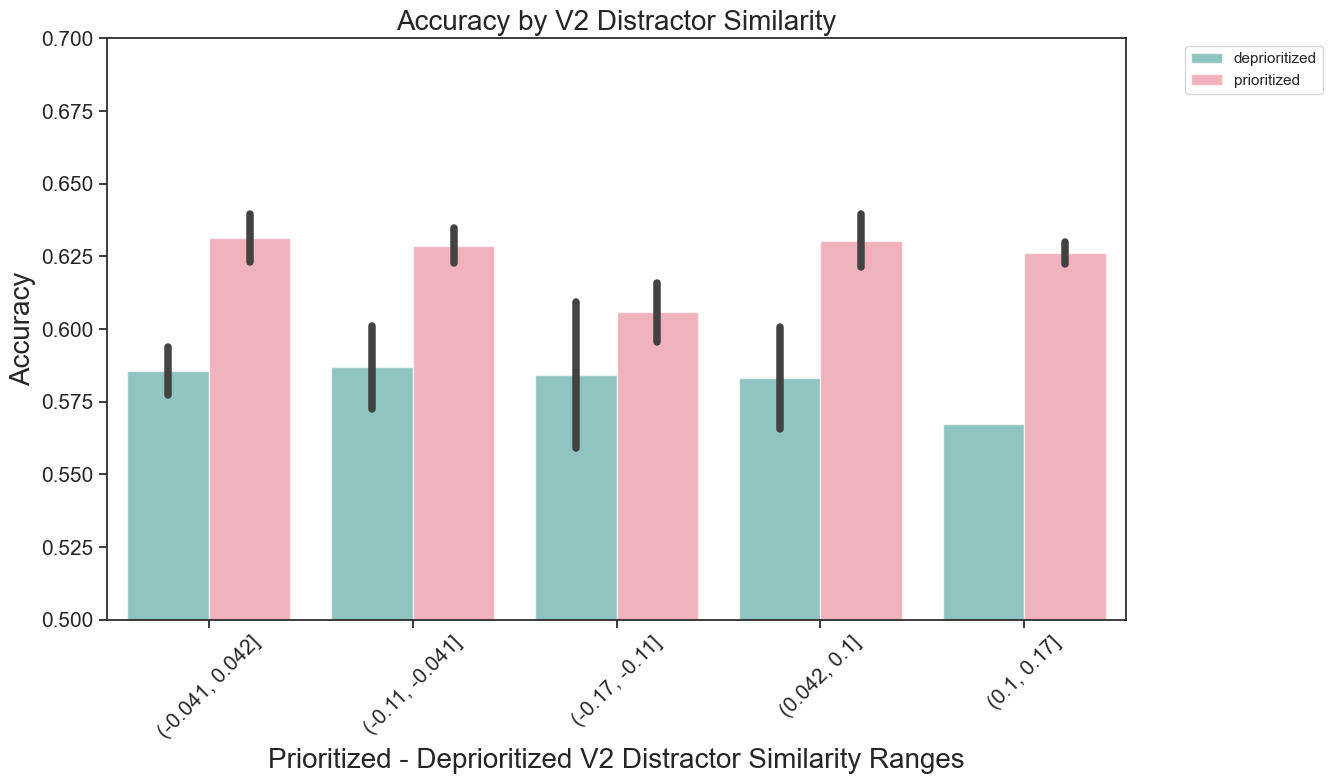

In [13]:
def plot_similarity_accuracy(data_x, x_column, y_column, tested_item_column, reliability_column, title):
    """
    Plots a bar plot for normalized accuracy by similarity ranges.
    """
    # Normalize the accuracy column to range between 0 and 1
    data = data_x.copy(deep=True)
    data[y_column] = (data[y_column] - data[y_column].min()) / (data[y_column].max() - data[y_column].min())
    
    # Ensure the similarity ranges are treated as strings for categorical plotting
    data[x_column] = data[x_column].astype(str)
    
    # Step 1: Calculate subject-level means
    subject_means = data.groupby([x_column, tested_item_column, reliability_column])[y_column].mean().reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.set(style="ticks", rc={"lines.linewidth": 3})

    # Bar plot for group means
    sns.barplot(
        x=x_column,
        y=y_column,
        hue=tested_item_column,
        palette=palette,
        data=subject_means,
        ax=ax,
        alpha=0.6
    )

    # Customize the plot appearance
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_ylim(0.5, 0.7)
    ax.set_xlabel(x_column.replace('_', ' '), fontsize=20)
    ax.set_ylabel(y_column, fontsize=20)
    ax.tick_params(axis='x', rotation=45, labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(title, fontsize=20)

    fig.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

plot_similarity_accuracy(
    data_x=df,
    x_column='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by IT Distractor Similarity"
)

plot_similarity_accuracy(
    data_x=df,
    x_column='Prioritized - Deprioritized V2 Distractor Similarity Ranges',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by V2 Distractor Similarity"
)


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/522848523.py:27: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


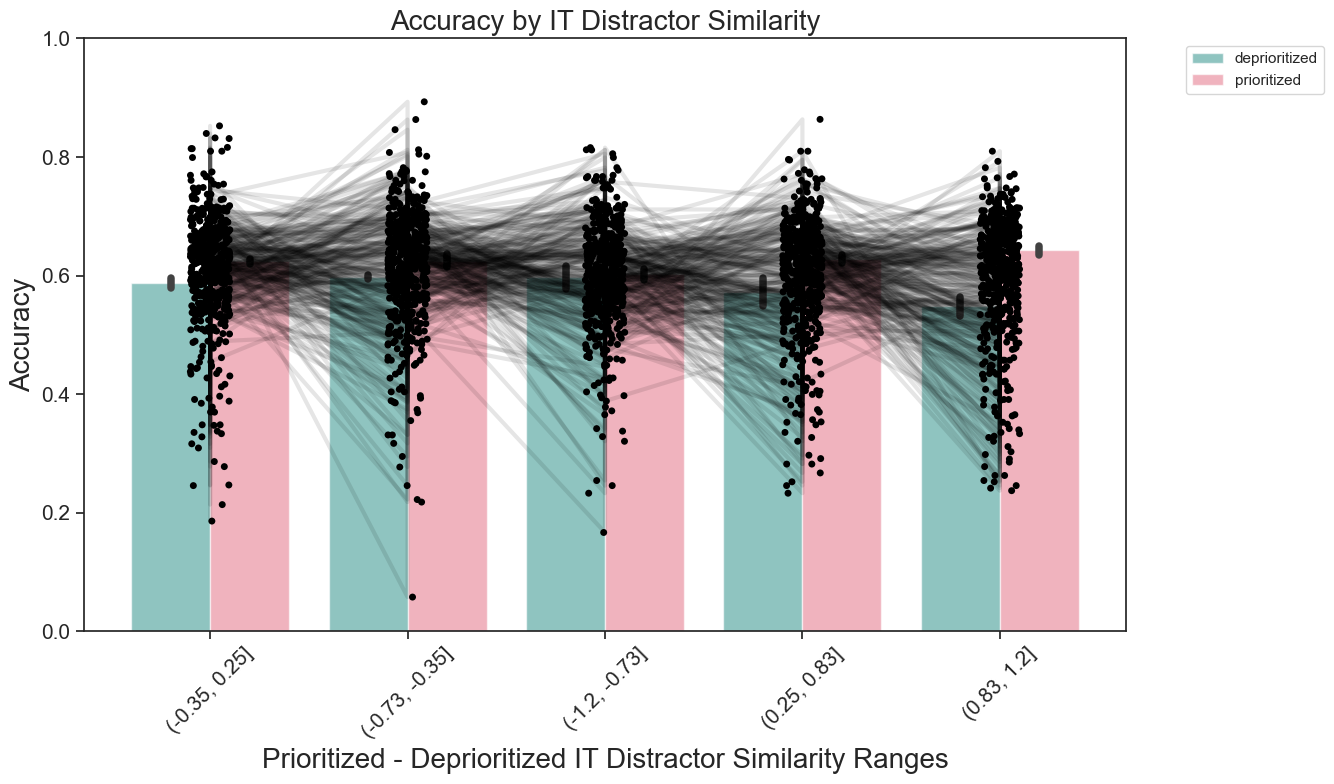

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/522848523.py:27: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


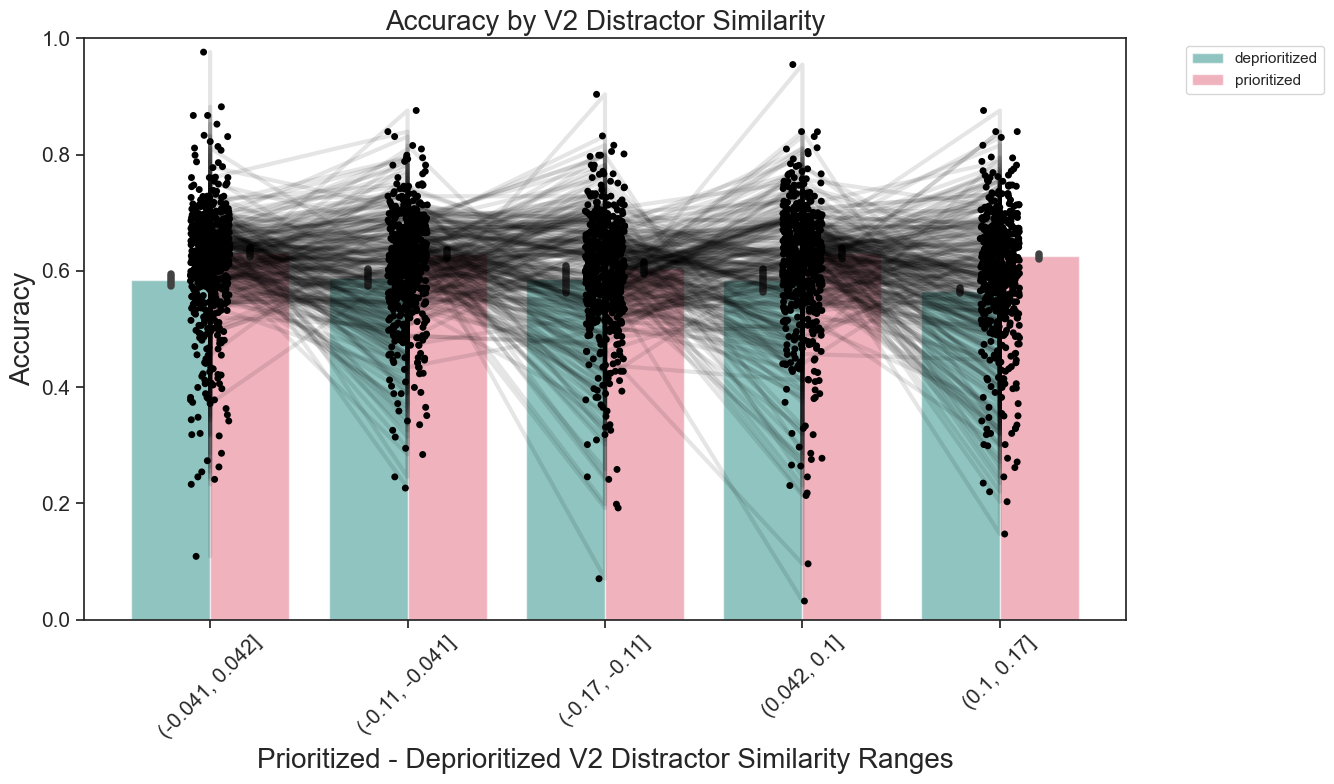

In [17]:

# palette_retrocue = {"high": "#1f77b4", "low": "#ff7f0e"}

def plot_similarity_accuracy(data_x, x_column, y_column, participant_column, tested_item_column, reliability_column, title):
    """
    Plots a bar plot with individual points and connection lines for normalized accuracy by similarity ranges.
    """
    
    data = data_x.copy(deep=True)

    # Normalize the accuracy column to range between 0 and 1
    data[y_column] = (data[y_column] - data[y_column].min()) / (data[y_column].max() - data[y_column].min())
    
    # Ensure the similarity ranges are treated as strings for categorical plotting
    data[x_column] = data[x_column].astype(str)
    
    # Step 1: Calculate subject-level means
    subject_means = data.groupby([participant_column, x_column, tested_item_column, reliability_column])[y_column].mean().reset_index()

    # Step 2: Calculate the mean of subject-level means for each similarity range and tested item category
    group_means = subject_means.groupby([x_column, tested_item_column, reliability_column])[y_column].mean().reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.set(style="ticks", rc={"lines.linewidth": 3})

    # Strip plot for individual data points
    sns.stripplot(
        x=x_column,
        y=y_column,
        data=subject_means,
        hue=tested_item_column,
        palette=['black'],
        marker="o",
        jitter=True,
        s=5,
        zorder=10,
        ax=ax
    )

    # Bar plot for group means
    sns.barplot(
        x=x_column,
        y=y_column,
        hue=tested_item_column,
        palette=palette,
        data=group_means,
        ax=ax,
        alpha=0.6
    )

    # Connect individual points for each participant across categories
    for subject in subject_means[participant_column].unique():
        subset = subject_means[subject_means[participant_column] == subject]
        for reliability in subset[reliability_column].unique():
            sub_subset = subset[subset[reliability_column] == reliability]
            if sub_subset.shape[0] > 1:
                ax.plot(
                    sub_subset[x_column],
                    sub_subset[y_column],
                    color="black",
                    alpha=0.1
                )

    # Customize the plot appearance
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_ylim(0, 1)
    ax.set_xlabel(x_column.replace('_', ' '), fontsize=20)
    ax.set_ylabel(y_column, fontsize=20)
    ax.tick_params(axis='x', rotation=45, labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(title, fontsize=20)

    fig.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Example usage for IT
plot_similarity_accuracy(
    data_x=df,
    x_column='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y_column='Accuracy',
    participant_column='participant',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by IT Distractor Similarity"
)

# Example usage for V2
plot_similarity_accuracy(
    data_x=df,
    x_column='Prioritized - Deprioritized V2 Distractor Similarity Ranges',
    y_column='Accuracy',
    participant_column='participant',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by V2 Distractor Similarity"
)


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/1589601801.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/1589601801.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


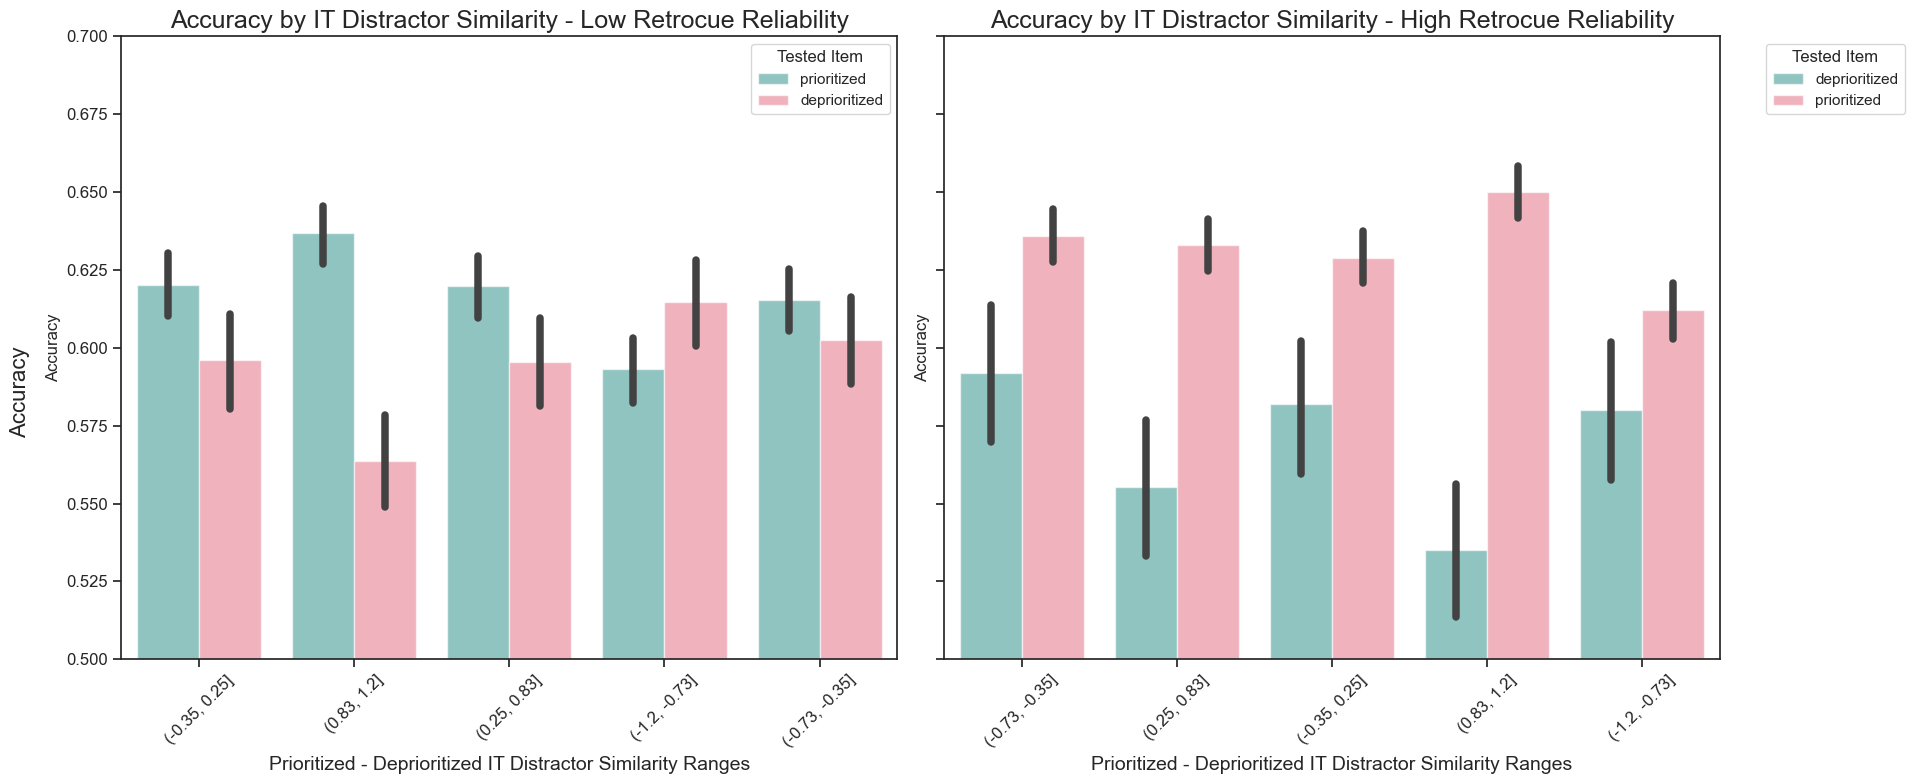

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/1589601801.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/1589601801.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


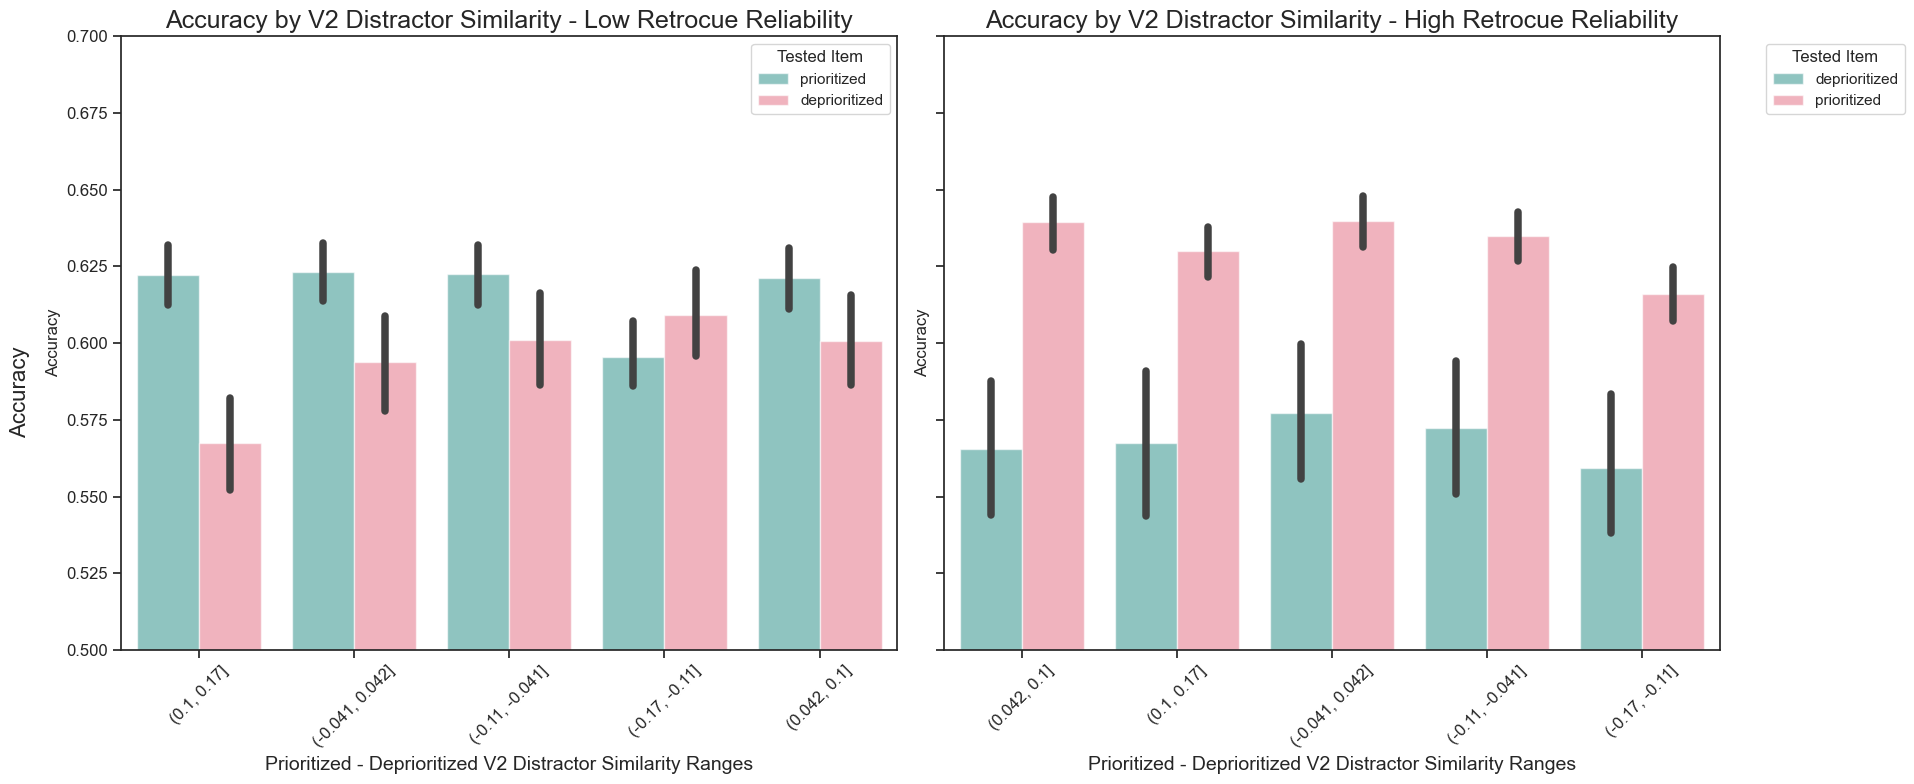

In [18]:


def plot_similarity_accuracy(data_x, x_column, y_column, tested_item_column, reliability_column, title):
    """
    Plots two separate bar plots for normalized accuracy by similarity ranges, split by high and low Retrocue Reliability,
    with confidence intervals computed automatically by Seaborn.
    
    Parameters:
    - data_x (pd.DataFrame): The input dataframe.
    - x_column (str): The name of the column to use for the x-axis.
    - y_column (str): The name of the column to use for the y-axis.
    - tested_item_column (str): The column name indicating 'Tested Item'.
    - reliability_column (str): The column name for retrocue reliability.
    - title (str): Title for the plot.
    """
    # Create a copy of the data to avoid modifying the original
    data = data_x.copy(deep=True)
    
    # Normalize the accuracy column to range between 0 and 1
    data[y_column] = (data[y_column] - data[y_column].min()) / (data[y_column].max() - data[y_column].min())
    
    # Ensure the similarity ranges are treated as strings for categorical plotting
    data[x_column] = data[x_column].astype(str)
    
    # Set up subplots for the two levels of Retrocue Reliability
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    sns.set(style="ticks", rc={"lines.linewidth": 3})

    # Iterate over the two levels of Retrocue Reliability and plot each
    for i, reliability_level in enumerate(['low', 'high']):
        # Filter data for the current reliability level
        data_subset = data[data[reliability_column] == reliability_level]

        # Bar plot with Seaborn's automatic confidence interval calculation
        sns.barplot(
            x=x_column,
            y=y_column,
            hue=tested_item_column,
            palette=palette,
            data=data_subset,
            ax=axes[i],
            alpha=0.6,
            ci=95  # Set confidence interval to 95%
        )

        # Customize plot appearance for each subplot
        axes[i].set_ylim(0.5, 0.7)
        axes[i].set_title(f"{title} - {reliability_level.capitalize()} Retrocue Reliability", fontsize=18)
        axes[i].set_xlabel(x_column.replace('_', ' '), fontsize=14)
        axes[i].tick_params(axis='x', rotation=45, labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
    
    # Set a common y-axis label
    fig.text(0.04, 0.5, y_column, va='center', rotation='vertical', fontsize=16)

    # Adjust layout and show plot
    fig.tight_layout(rect=[0.05, 0, 1, 1])
    plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Example usage for IT and V2 with split by Retrocue Reliability
plot_similarity_accuracy(
    data_x=df,
    x_column='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by IT Distractor Similarity"
)

plot_similarity_accuracy(
    data_x=df,
    x_column='Prioritized - Deprioritized V2 Distractor Similarity Ranges',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by V2 Distractor Similarity"
)


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/4247286183.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/4247286183.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


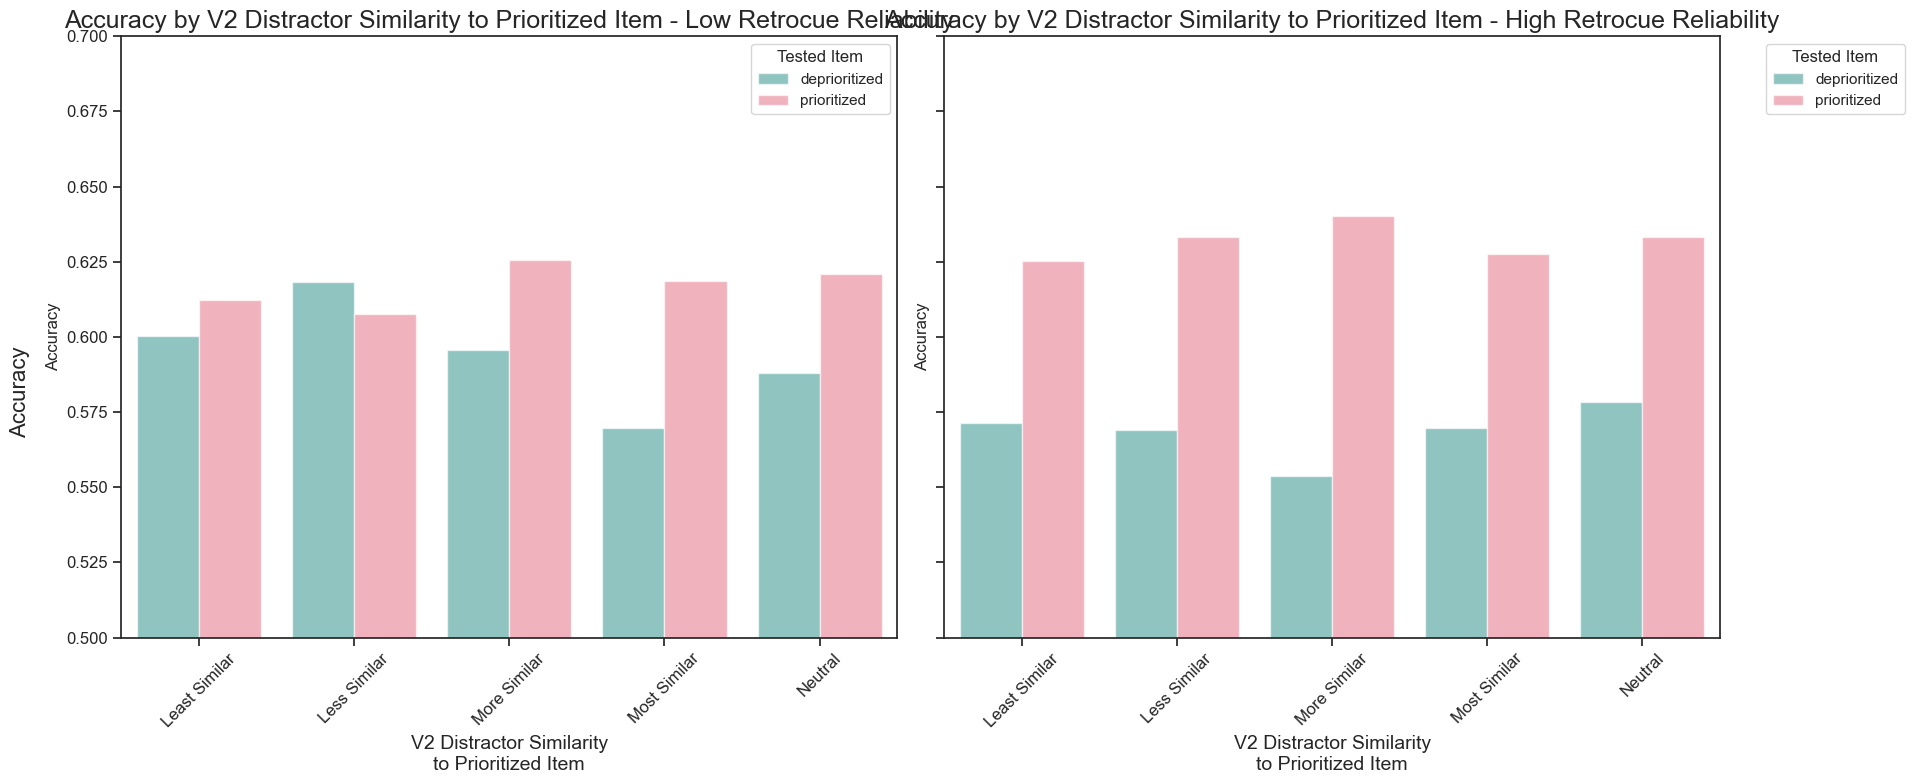

In [22]:


def plot_similarity_accuracy(data_x, x_column, y_column, tested_item_column, reliability_column, title):
    """
    Plots two separate bar plots for normalized accuracy by similarity ranges, split by Retrocue Reliability.

    Parameters:
    - data (pd.DataFrame): The input dataframe.
    - x_column (str): The name of the column to use for the x-axis.
    - y_column (str): The name of the column to use for the y-axis.
    - tested_item_column (str): The column name indicating 'Tested Item'.
    - reliability_column (str): The column name for retrocue reliability.
    - title (str): Title for the plot.
    """
    data = data_x.copy(deep=True)

    # Normalize the accuracy column to range between 0 and 1
    data[y_column] = (data[y_column] - data[y_column].min()) / (data[y_column].max() - data[y_column].min())
    
    # Ensure the x-axis column is treated as a categorical variable
    data[x_column] = data[x_column].astype(str)
    
    # Set up subplots for the two levels of Retrocue Reliability
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    sns.set(style="ticks", rc={"lines.linewidth": 3})

    # Iterate over the two levels of Retrocue Reliability and plot each
    for i, reliability_level in enumerate(['low', 'high']):
        # Filter data for the current reliability level
        data_subset = data[data[reliability_column] == reliability_level]
        
        # Step 1: Calculate subject-level means for the subset
        subject_means = data_subset.groupby([x_column, tested_item_column])[y_column].mean().reset_index()

        # Bar plot for group means
        sns.barplot(
            x=x_column,
            y=y_column,
            hue=tested_item_column,
            palette=palette,
            data=subject_means,
            ax=axes[i],
            ci = 95,
            alpha=0.6
        )

        # Customize plot appearance for each subplot
        axes[i].set_ylim(0.5, 0.7)
        axes[i].set_title(f"{title} - {reliability_level.capitalize()} Retrocue Reliability", fontsize=18)
        axes[i].set_xlabel(x_column.replace('_', ' '), fontsize=14)
        axes[i].tick_params(axis='x', rotation=45, labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
    
    # Set a common y-axis label
    fig.text(0.04, 0.5, y_column, va='center', rotation='vertical', fontsize=16)

    # Adjust layout and show plot
    fig.tight_layout(rect=[0.05, 0, 1, 1])
    plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Example usage for V2 with categorical values in x_column, split by Retrocue Reliability
plot_similarity_accuracy(
    data_x=df,
    x_column='V2 Distractor Similarity\nto Prioritized Item',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by V2 Distractor Similarity to Prioritized Item"
)


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/4247286183.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/4247286183.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


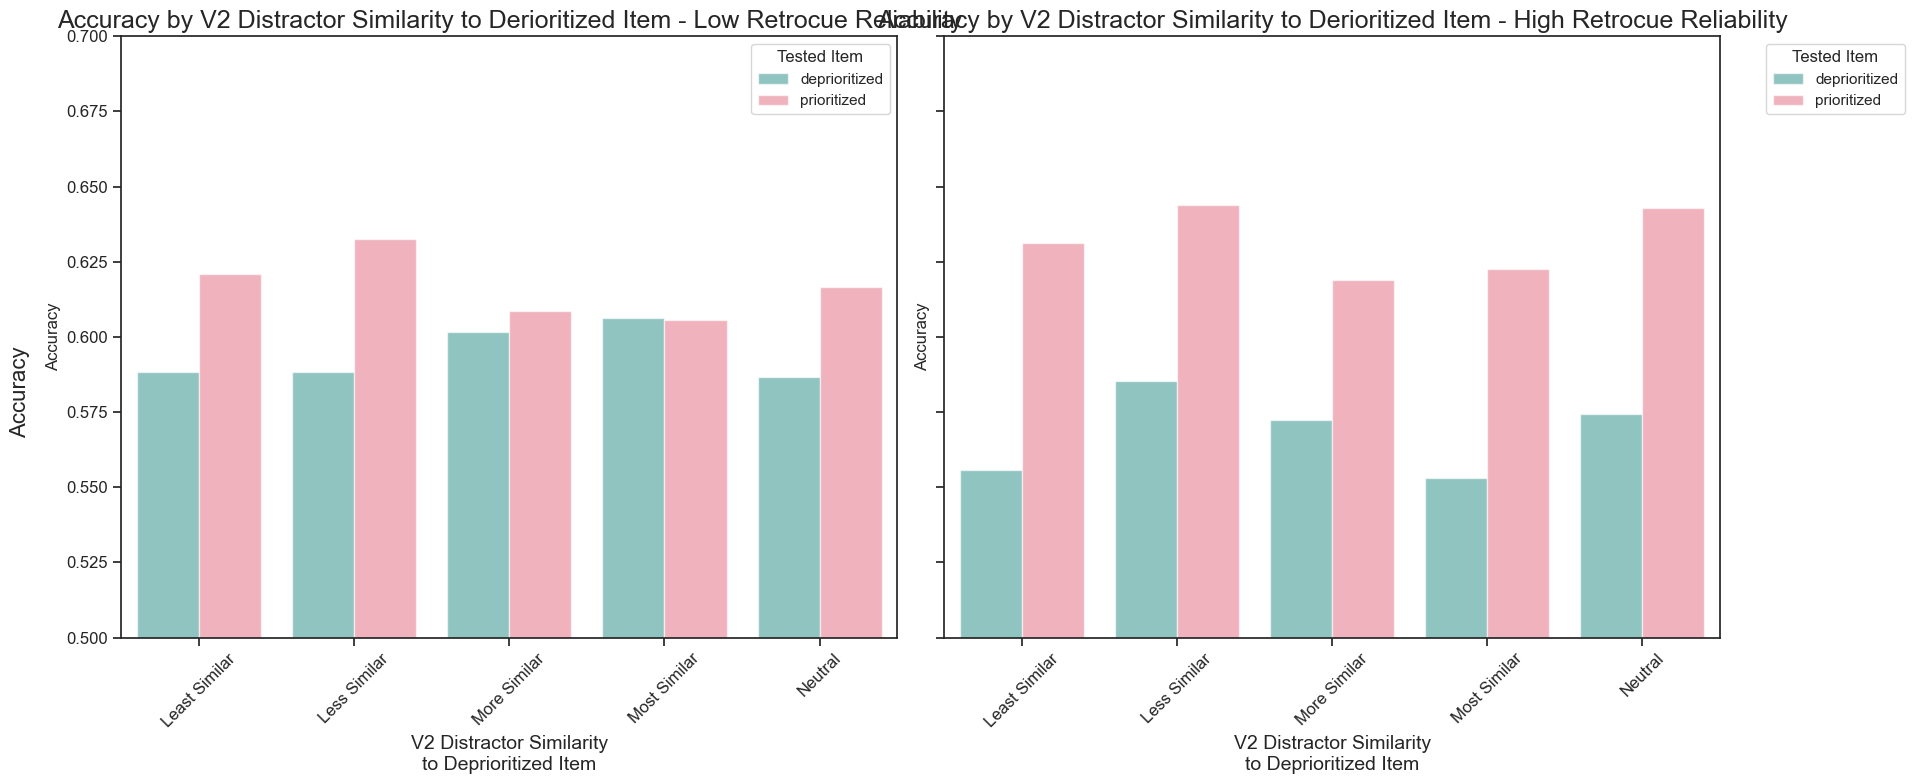

In [24]:
plot_similarity_accuracy(
    data_x=df,
    x_column='V2 Distractor Similarity\nto Deprioritized Item',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by V2 Distractor Similarity to Derioritized Item"
)


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/4247286183.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/4247286183.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


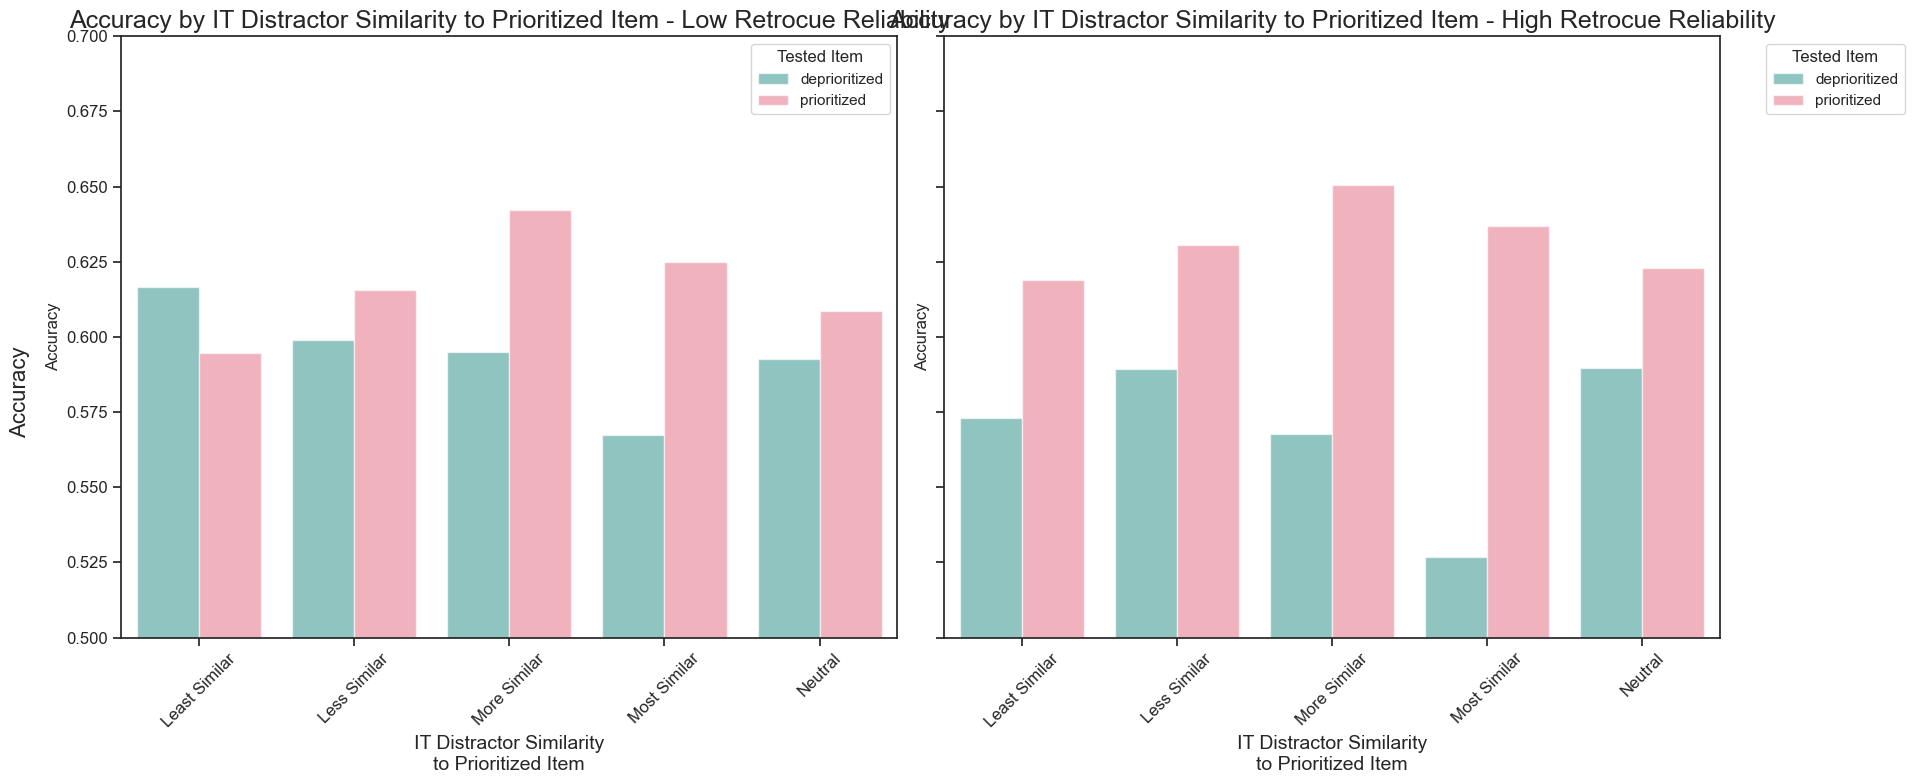

In [25]:
plot_similarity_accuracy(
    data_x=df,
    x_column='IT Distractor Similarity\nto Prioritized Item',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by IT Distractor Similarity to Prioritized Item"
)


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/4247286183.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/4247286183.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


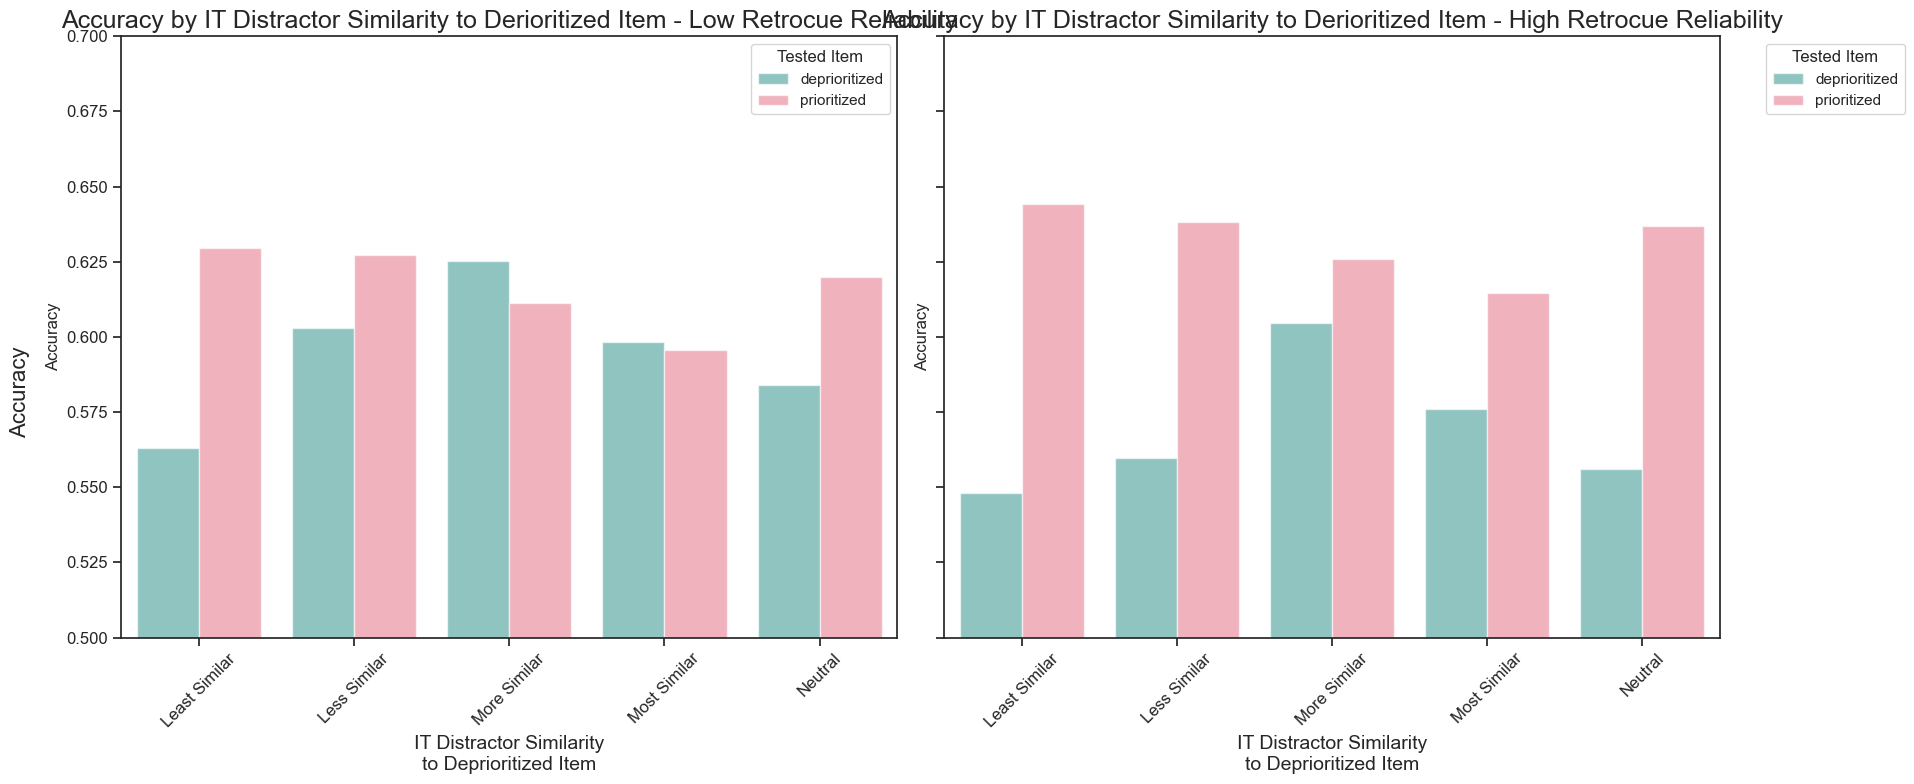

In [26]:
plot_similarity_accuracy(
    data_x=df,
    x_column='IT Distractor Similarity\nto Deprioritized Item',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by IT Distractor Similarity to Derioritized Item"
)


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/1687597790.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


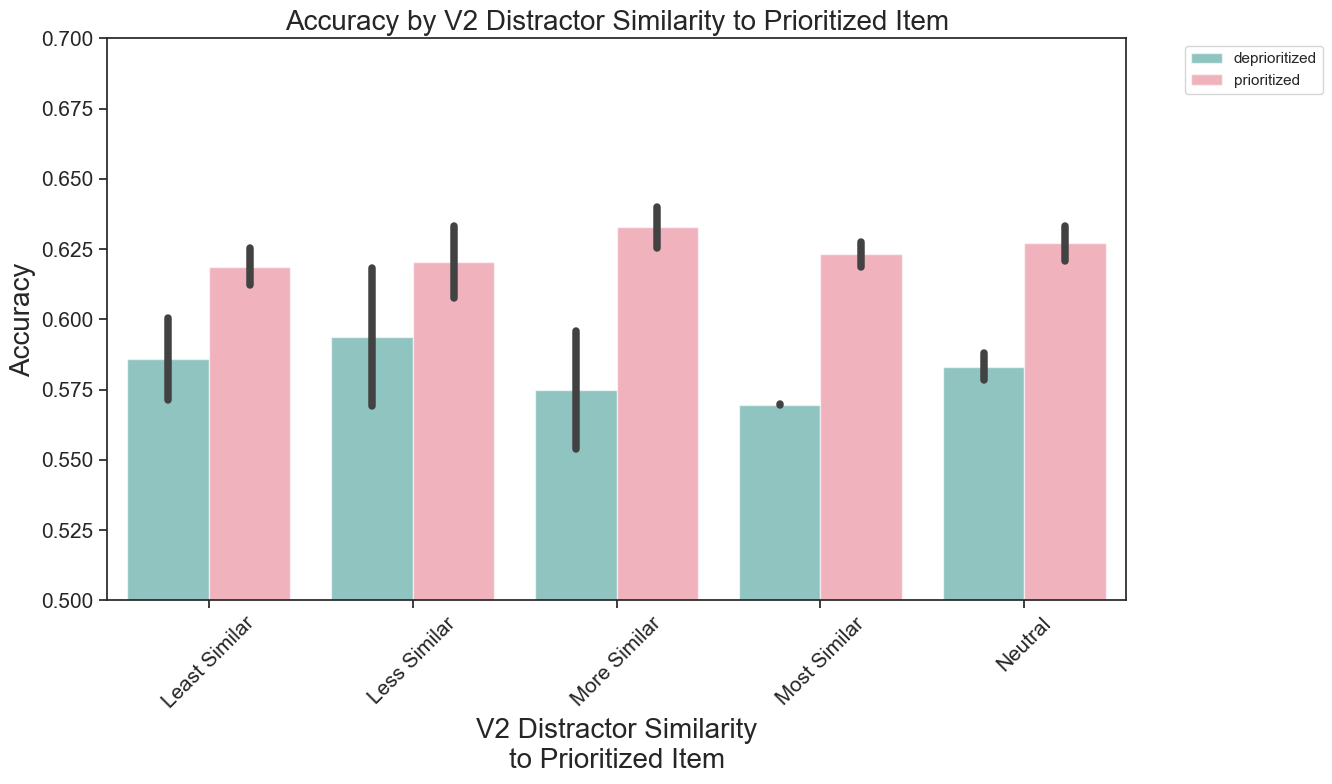

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/1687597790.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


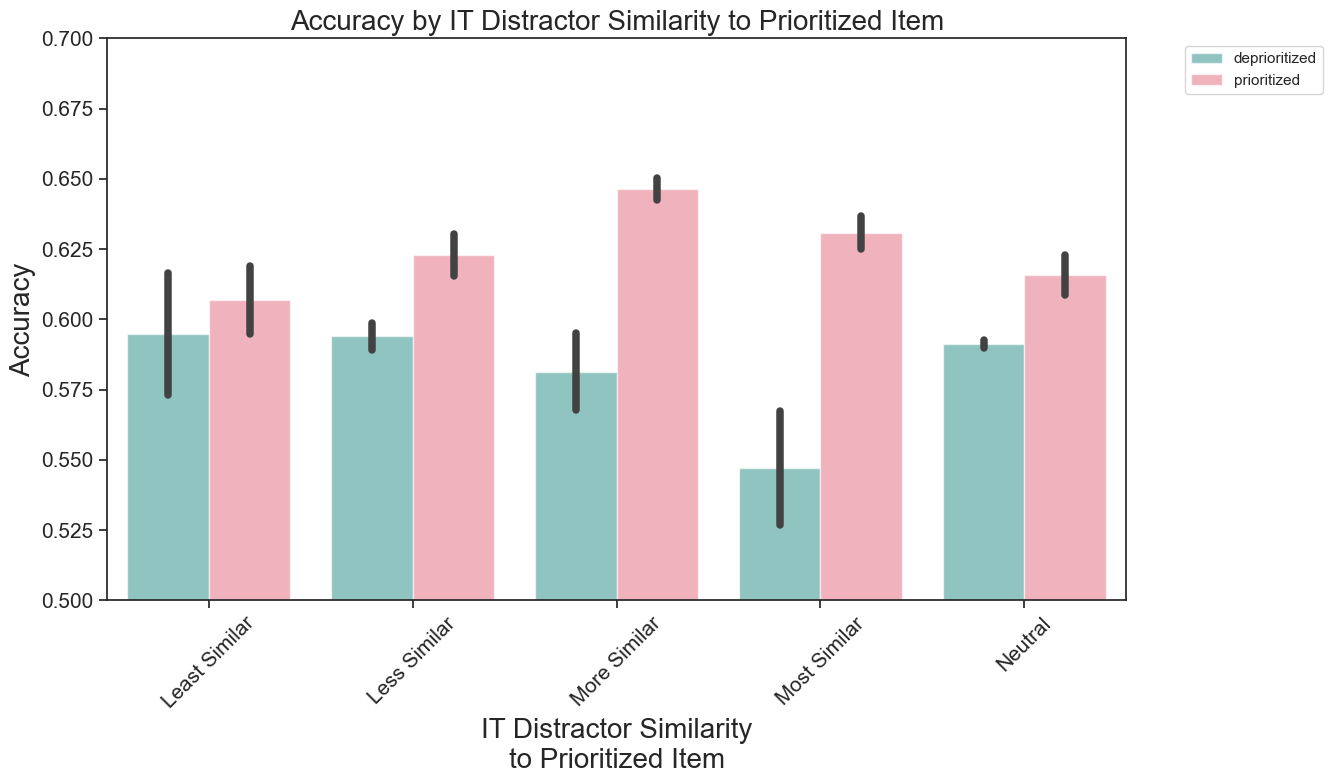

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/1687597790.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


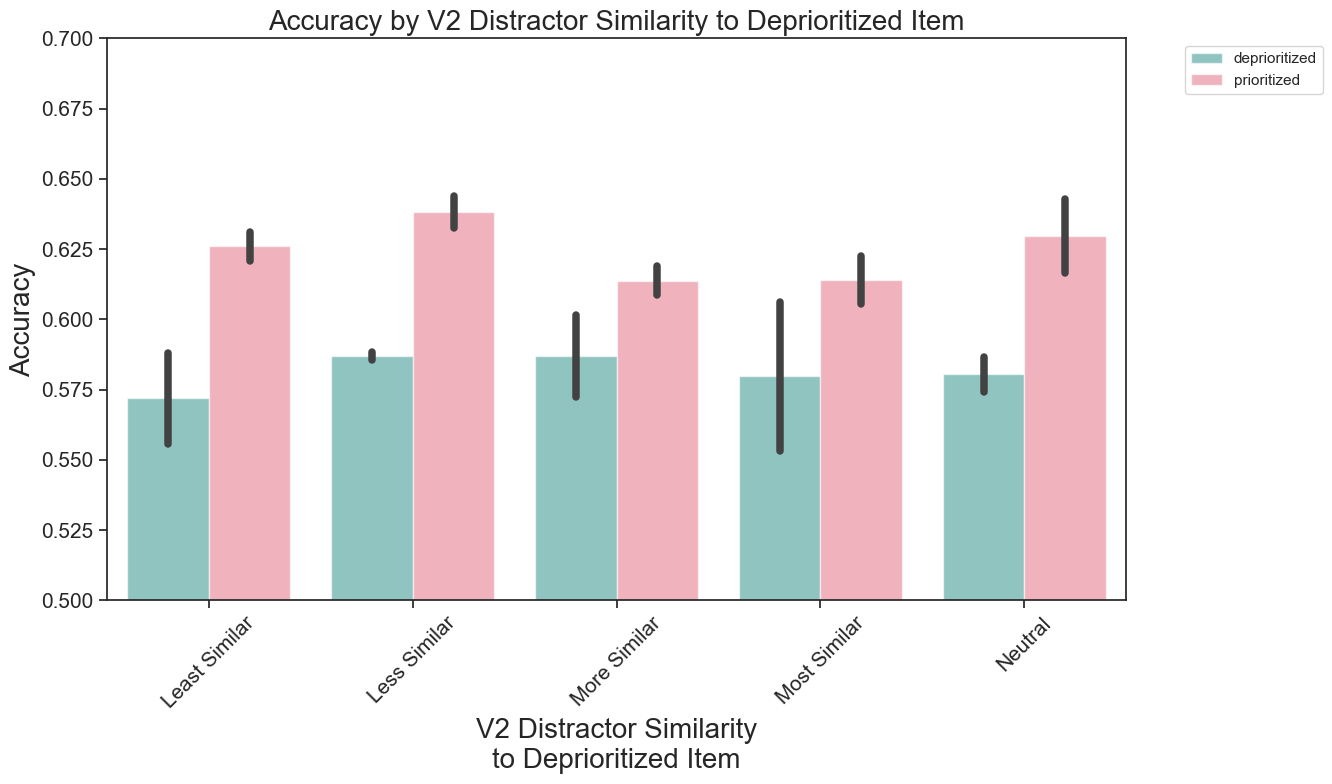

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/1687597790.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


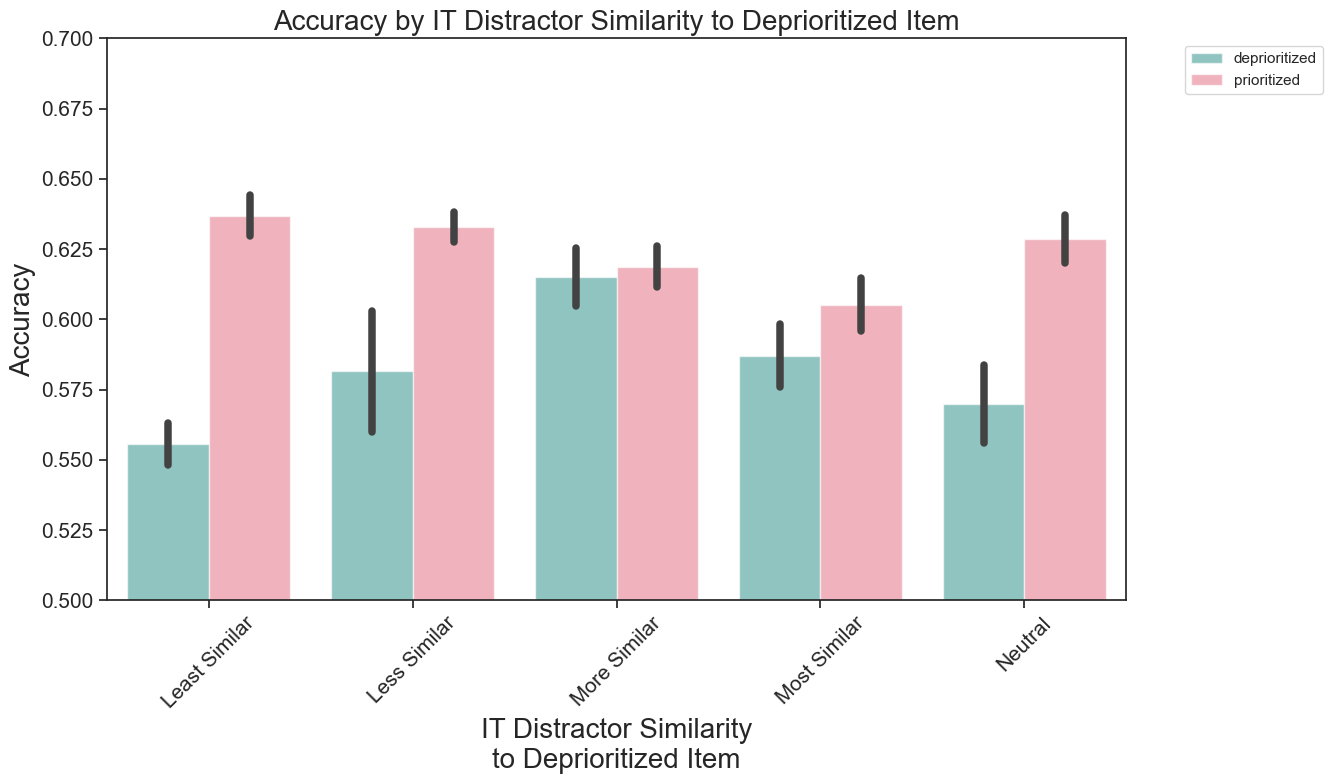

In [27]:


def plot_similarity_accuracy(data, x_column, y_column, tested_item_column, reliability_column, title):
    """
    Plots a bar plot for normalized accuracy by similarity ranges, handling categorical x-axis values.

    Parameters:
    - data (pd.DataFrame): The input dataframe.
    - x_column (str): The name of the column to use for the x-axis.
    - y_column (str): The name of the column to use for the y-axis.
    - tested_item_column (str): The column name indicating 'Tested Item'.
    - reliability_column (str): The column name for retrocue reliability.
    - title (str): Title for the plot.
    """
    # Normalize the accuracy column to range between 0 and 1
    data_x = data.copy(deep=True)
    data_x[y_column] = (data_x[y_column] - data_x[y_column].min()) / (data_x[y_column].max() - data_x[y_column].min())
    
    # Ensure the x-axis column is treated as a categorical variable
    data_x[x_column] = data_x[x_column].astype(str)
    
    # Step 1: Calculate subject-level means
    subject_means = data_x.groupby([x_column, tested_item_column, reliability_column])[y_column].mean().reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.set(style="ticks", rc={"lines.linewidth": 3})

    # Bar plot for group means
    sns.barplot(
        x=x_column,
        y=y_column,
        hue=tested_item_column,
        palette=palette,
        data=subject_means,
        ax=ax,
        ci = 95,
        alpha=0.6
    )

    # Customize the plot appearance
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_ylim(0.5, 0.7)
    ax.set_xlabel(x_column.replace('_', ' '), fontsize=20)
    ax.set_ylabel(y_column, fontsize=20)
    ax.tick_params(axis='x', rotation=45, labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(title, fontsize=20)

    fig.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Example usage for V2 with categorical values in x_column
plot_similarity_accuracy(
    data=df,
    x_column='V2 Distractor Similarity\nto Prioritized Item',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by V2 Distractor Similarity to Prioritized Item"
)

plot_similarity_accuracy(
    data=df,
    x_column='IT Distractor Similarity\nto Prioritized Item',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by IT Distractor Similarity to Prioritized Item"
)

plot_similarity_accuracy(
    data=df,
    x_column='V2 Distractor Similarity\nto Deprioritized Item',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by V2 Distractor Similarity to Deprioritized Item"
)

plot_similarity_accuracy(
    data=df,
    x_column='IT Distractor Similarity\nto Deprioritized Item',
    y_column='Accuracy',
    tested_item_column='Tested Item',
    reliability_column='Retrocue Reliability',
    title="Accuracy by IT Distractor Similarity to Deprioritized Item"
)


In [ ]:
# df['V2 Distractor Similarity\nto Prioritized Item']

In [ ]:
# nan_values = df['V2 Distractor Similarity\nto Prioritized Item'].isna()
# rows_with_nan = df[nan_values]
# print(rows_with_nan)


In [ ]:
df['validity_binary'] = df['Tested Item'].apply(lambda x: 1 if x == 'prioritized' else 0)
df['reliability_binary'] = df['Retrocue Reliability'].apply(lambda x: 1 if x == 'high' else 0)


In [29]:

# palette_retrocue = {"high": "#1f77b4", "low": "#ff7f0e"}

# # Function to calculate subject-level means, then average across those means, and create the bar plot
# def plot_retrocue_reliability_bar(data_x, title, color):
#     # Step 1: Calculate subject-level means
#     data = data_x.copy(deep=True)

#     subject_means = data.groupby(['participant', 'IT_diff_binned'])['Accuracy'].mean().reset_index()

#     # Step 2: Calculate the mean of the subject-level means for each IT_diff_binned category
#     group_means = subject_means.groupby('IT_diff_binned')['Accuracy'].mean().reset_index()

#     # Plotting the averaged data
#     plt.figure(figsize=(10, 6))
    
#     sns.barplot(
#         x='IT_diff_binned',
#         y='Accuracy',
#         palette=[color],  # Apply specific color for reliability level
#         data=group_means,
#         ci=68  # Confidence interval set to 68%
#     )
    
#     # Customizing the plot appearance
#     plt.ylim(0.65, 0.8)  # Set y-axis limits
#     plt.ylabel('Accuracy')
#     plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity')
#     plt.title(title)
#     plt.show()

# # Example usage for high retrocue reliability
# plot_retrocue_reliability_bar(df_high_retrocue, "Accuracy by IT Distractor Similarity (High Retrocue Reliability)", palette_retrocue["high"])

# # Example usage for low retrocue reliability
# plot_retrocue_reliability_bar(df_low_retrocue, "Accuracy by IT Distractor Similarity (Low Retrocue Reliability)", palette_retrocue["low"])


NameError: name 'df_high_retrocue' is not defined

In [ ]:
# 'Prioritized - Deprioritized V2 Distractor Similarity Ranges'

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/1293112808.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


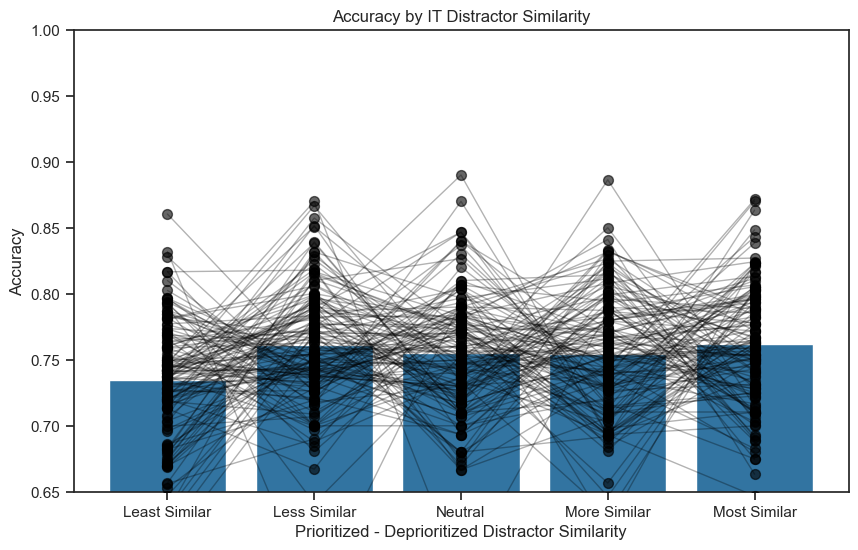

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/1293112808.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


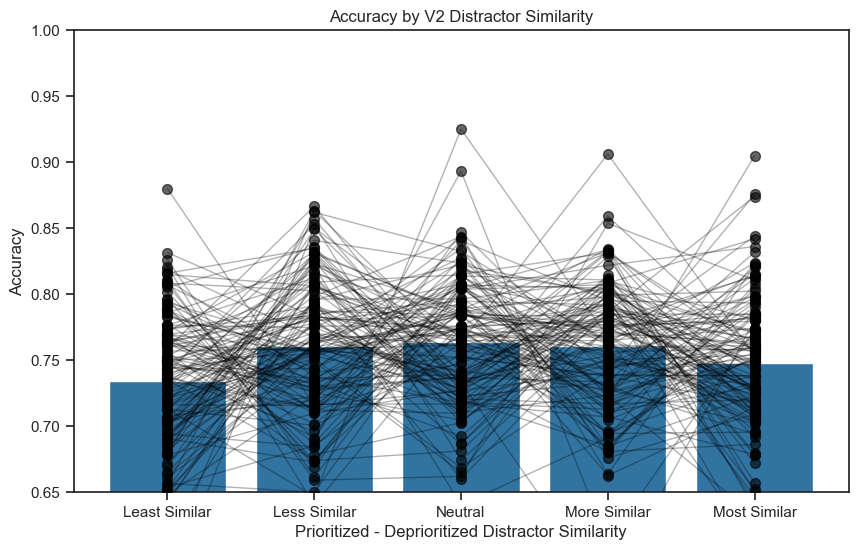

In [31]:

single_color = "#1f77b4"

# Generalized function to calculate subject-level means and create the bar plot
def plot_similarity_accuracy(data_x, x_column, y_column, participant_column, title):
    """
    Plots a bar chart of the average `y_column` by `x_column`, with individual subject points and connecting lines.

    Parameters:
    - data (pd.DataFrame): The input dataframe containing the data.
    - x_column (str): The name of the column to use for the x-axis (e.g., 'Prioritized - Deprioritized IT Distractor Similarity Ranges' or 'Prioritized - Deprioritized V2 Distractor Similarity Ranges').
    - y_column (str): The name of the column to use for the y-axis (e.g., 'Accuracy').
    - participant_column (str): The name of the column identifying unique participants (e.g., 'participant').
    - title (str): The title for the plot.
    """
    data = data_x.copy(deep=True)

    # Check if required columns exist in the dataframe
    if x_column not in data.columns or y_column not in data.columns or participant_column not in data.columns:
        print(f"Error: One or more specified columns ({x_column}, {y_column}, {participant_column}) do not exist in the dataframe.")
        return

    # Step 1: Calculate subject-level means
    subject_means = data.groupby([participant_column, x_column])[y_column].mean().reset_index()

    # Step 2: Calculate the mean of the subject-level means for each x_column category
    group_means = subject_means.groupby(x_column)[y_column].mean().reset_index()

    # Plotting the averaged data
    plt.figure(figsize=(10, 6))
    
    # Bar plot for group means
    sns.barplot(
        x=x_column,
        y=y_column,
        data=group_means,
        color=single_color,  # Use the specified color for the overall data
        ci=68  # Confidence interval set to 68%
    )
    
    # Plotting individual subject means as points and connecting them by lines
    for participant in subject_means[participant_column].unique():
        # Get data for each participant
        participant_data = subject_means[subject_means[participant_column] == participant]
        
        # Plot points for each participant
        plt.scatter(
            x=participant_data[x_column],
            y=participant_data[y_column],
            color="black",
            s=50,
            alpha=0.6,
            zorder=10  # Ensures points are on top of bars
        )
        
        # Connect points for each participant
        plt.plot(
            participant_data[x_column],
            participant_data[y_column],
            color="black",
            alpha=0.3,
            linewidth=1,
            zorder=9  # Ensures lines are behind points but above bars
        )

    # Customize plot appearance
    plt.ylim(0.65, 1)  # Set y-axis limits
    plt.ylabel('Accuracy')
    plt.xlabel('Prioritized - Deprioritized Distractor Similarity')
    plt.title(title)
    plt.show()

# Example usage for IT
plot_similarity_accuracy(df, x_column='Prioritized - Deprioritized IT Distractor Similarity', y_column="Accuracy", participant_column="participant", title="Accuracy by IT Distractor Similarity")

# Example usage for V2
plot_similarity_accuracy(df, x_column='Prioritized - Deprioritized V2 Distractor Similarity', y_column="Accuracy", participant_column="participant", title="Accuracy by V2 Distractor Similarity")


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/2506133525.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


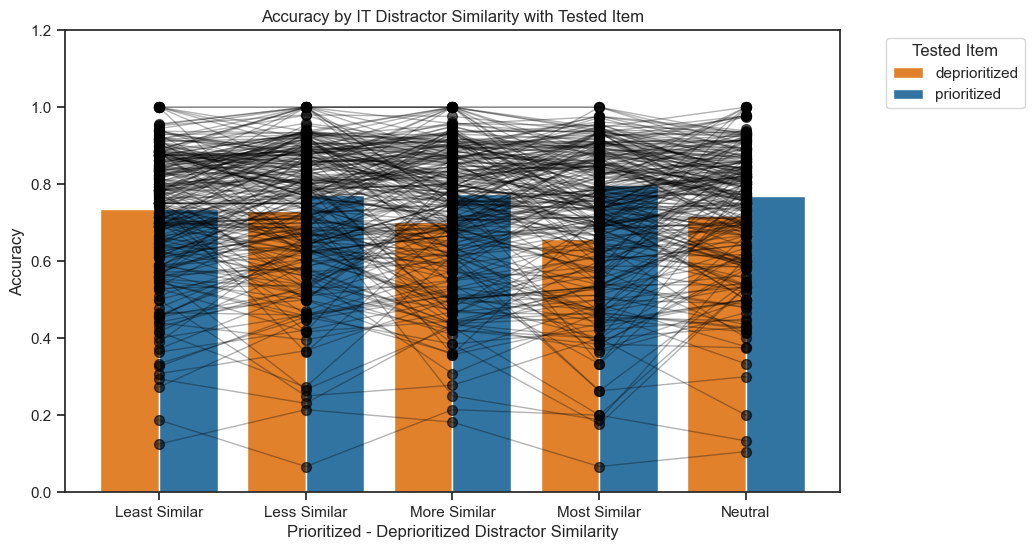

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/2506133525.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


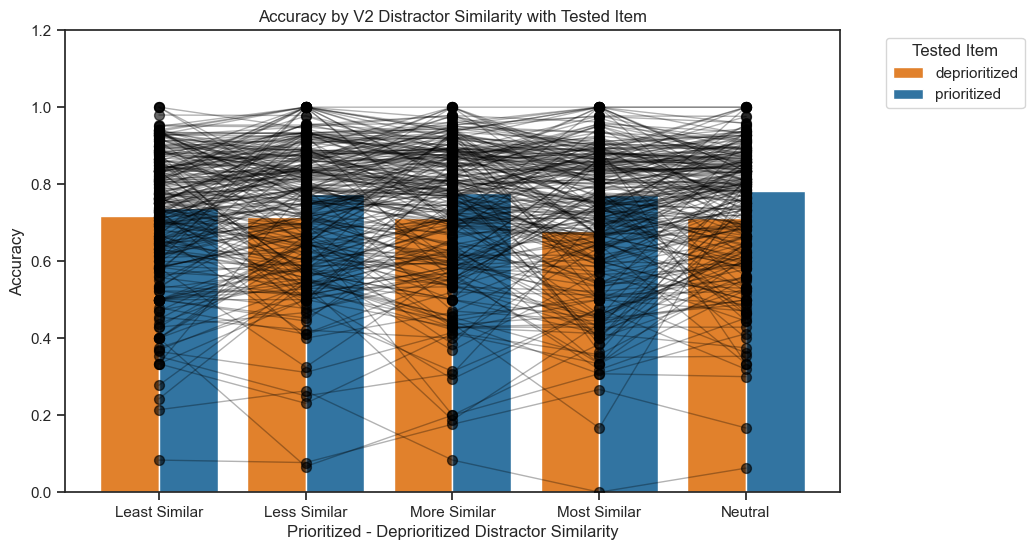

In [41]:

# Define color palette for Tested Item categories
tested_item_palette = {"prioritized": "#1f77b4", "deprioritized": "#ff7f0e"}

# Generalized function to calculate subject-level means and create the bar plot with Tested Item as a hue
def plot_similarity_accuracy(data_x, x_column, y_column, participant_column, tested_item_column, title):
    """
    Plots a bar chart of the average `y_column` by `x_column`, with individual subject points and connecting lines.

    Parameters:
    - data (pd.DataFrame): The input dataframe containing the data.
    - x_column (str): The name of the column to use for the x-axis (e.g., 'Prioritized - Deprioritized IT Distractor Similarity Ranges' or 'Prioritized - Deprioritized V2 Distractor Similarity Ranges').
    - y_column (str): The name of the column to use for the y-axis (e.g., 'Accuracy').
    - participant_column (str): The name of the column identifying unique participants (e.g., 'participant').
    - tested_item_column (str): The name of the column indicating Tested Item ('Prioritized' or 'Deprioritized').
    - title (str): The title for the plot.
    """
    data = data_x.copy(deep=True)

    # Check if required columns exist in the dataframe
    required_columns = {x_column, y_column, participant_column, tested_item_column}
    if not required_columns.issubset(data.columns):
        missing_columns = required_columns - set(data.columns)
        print(f"Error: Missing columns in the dataframe: {missing_columns}")
        return

    # Convert intervals to strings if x_column contains intervals
    data[x_column] = data[x_column].astype(str)

    # Step 1: Calculate subject-level means
    subject_means = data.groupby([participant_column, x_column, tested_item_column])[y_column].mean().reset_index()

    # Step 2: Calculate the mean of the subject-level means for each x_column and Tested Item category
    group_means = subject_means.groupby([x_column, tested_item_column])[y_column].mean().reset_index()

    # Plotting the averaged data
    plt.figure(figsize=(10, 6))
    
    # Bar plot for group means, with Tested Item as hue
    sns.barplot(
        x=x_column,
        y=y_column,
        hue=tested_item_column,
        data=group_means,
        palette=tested_item_palette,  # Color based on Tested Item (Prioritized vs Deprioritized)
        ci=68  # Confidence interval set to 68%
    )
    
    # Plotting individual subject means as points and connecting them by lines within each Tested Item category
    for participant in subject_means[participant_column].unique():
        # Get data for each participant
        participant_data = subject_means[subject_means[participant_column] == participant]
        
        # Plot points for each Tested Item category for each participant
        for tested_item in participant_data[tested_item_column].unique():
            tested_item_data = participant_data[participant_data[tested_item_column] == tested_item]
            
            # Plot points
            plt.scatter(
                x=tested_item_data[x_column],
                y=tested_item_data[y_column],
                color="black",
                s=50,
                alpha=0.6,
                zorder=10
            )
            
            # Connect points for each participant within Tested Item categories
            plt.plot(
                tested_item_data[x_column],
                tested_item_data[y_column],
                color="black",
                alpha=0.3,
                linewidth=1,
                zorder=9
            )

    # Customize plot appearance
    plt.ylim(0, 1.2)  # Set y-axis limits
    plt.ylabel('Accuracy')
    plt.xlabel('Prioritized - Deprioritized Distractor Similarity')
    plt.title(title)
    plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside plot
    plt.show()

# Example usage for IT with Tested Item
plot_similarity_accuracy(
    df,
    x_column='Prioritized - Deprioritized IT Distractor Similarity',
    y_column="Accuracy",
    participant_column="participant",
    tested_item_column="Tested Item",
    title="Accuracy by IT Distractor Similarity with Tested Item"
)

# Example usage for V2 with Tested Item
plot_similarity_accuracy(
    df,
    x_column='Prioritized - Deprioritized V2 Distractor Similarity',
    y_column="Accuracy",
    participant_column="participant",
    tested_item_column="Tested Item",
    title="Accuracy by V2 Distractor Similarity with Tested Item"
)


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/651565855.py:13: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


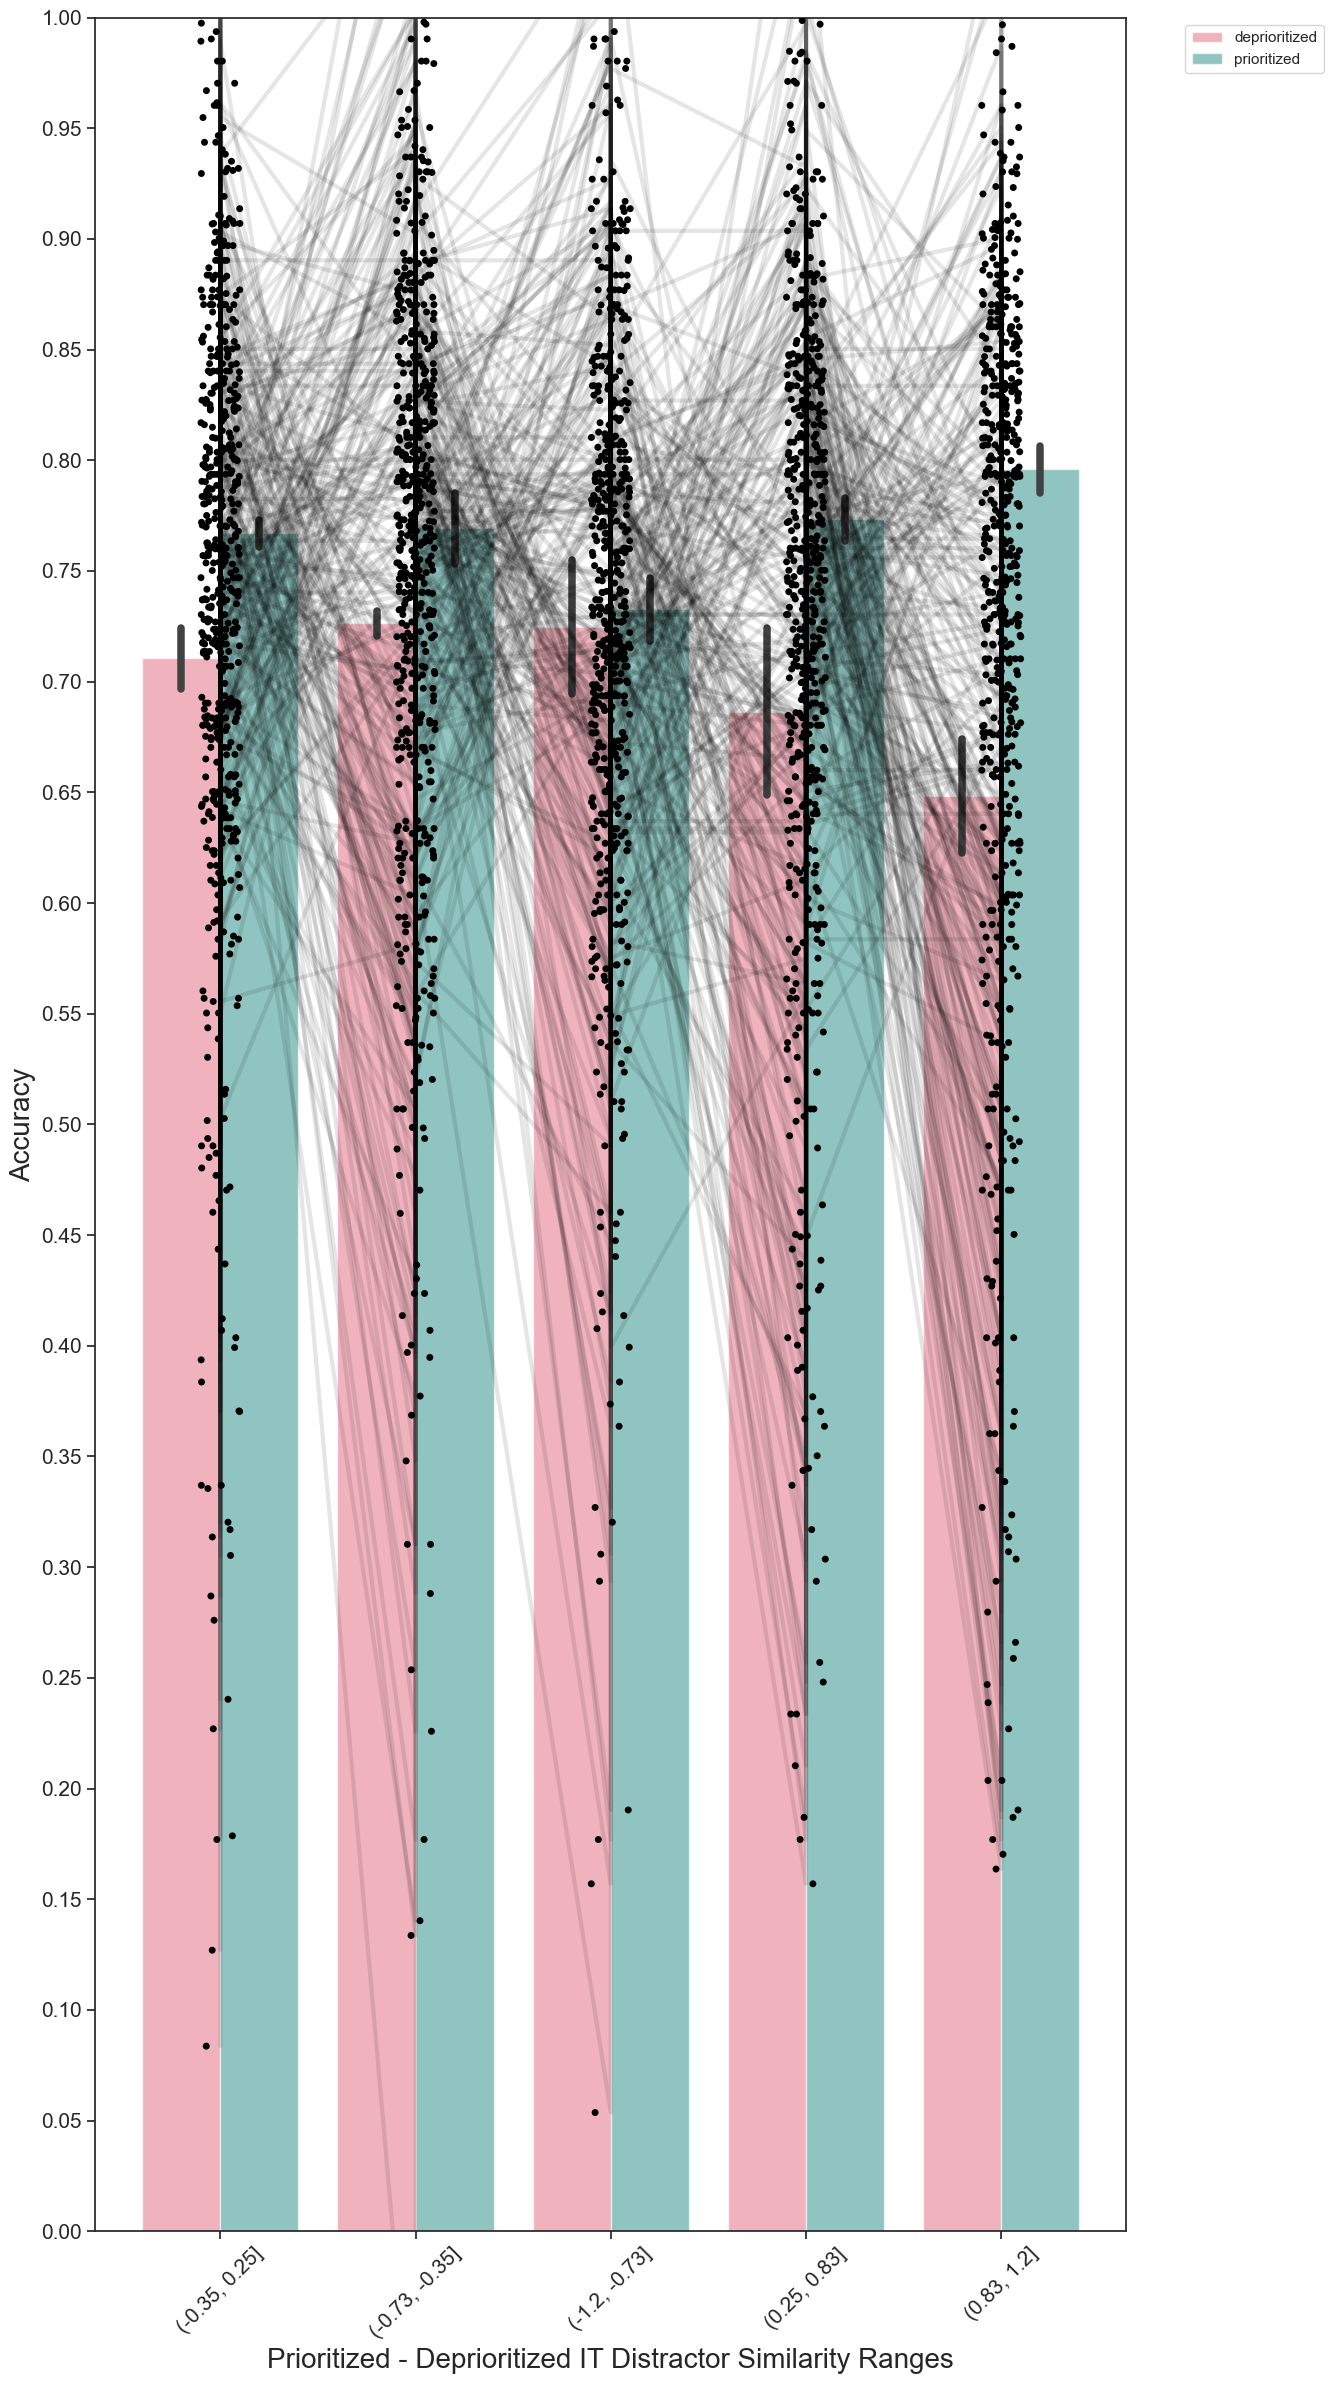

In [34]:
palette_retrocue = {"high": "#1f77b4", "low": "#ff7f0e"}  # Customize as needed

df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['Prioritized - Deprioritized IT Distractor Similarity Ranges'].astype(str)

subject_means = df.groupby(['participant', 'Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item', 'Retrocue Reliability'])['Accuracy'].mean().reset_index()
group_means = subject_means.groupby(['Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item', 'Retrocue Reliability'])['Accuracy'].mean().reset_index()


fig, ax = plt.subplots(figsize=(16, 24))  # Increase figure size for better visibility
sns.set(style="ticks", rc={"lines.linewidth": 3})

# Create a stripplot for individual subject-level means with jitter for separation
sns.stripplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='Accuracy',
    data=subject_means,
    hue='Tested Item',
    palette=['black'],
    marker="o",
    jitter=True,
    s=5,
    zorder=10,
    ax=ax
)

# Overlay the bar plot for the mean accuracy across subjects in each group
sns.barplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='Accuracy',
    hue='Tested Item',
    palette=palette[::-1],
    data=group_means,
    ax=ax,
    alpha=0.6
)

# Connect individual points to show change across categories for each subject
unique_subjects = subject_means['participant'].unique()
for subject in unique_subjects:
    subset = subject_means[subject_means['participant'] == subject]
    for reliability in subset['Retrocue Reliability'].unique():
        sub_subset = subset[subset['Retrocue Reliability'] == reliability]
        if sub_subset.shape[0] > 1:
            ax.plot(
                sub_subset['Prioritized - Deprioritized IT Distractor Similarity Ranges'],
                sub_subset['Accuracy'],
                color="black",
                alpha=0.1
            )

# Customize axis and plot appearance
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates by creating a dictionary
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Customize axis and plot appearance
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set_ylim(0, 1)
ax.set_xlabel("Prioritized - Deprioritized IT Distractor Similarity Ranges", fontsize=20)
ax.set_ylabel("Accuracy", fontsize=20)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.tick_params(axis='y', labelsize=15)

fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to create space for the legend
plt.show()




/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/3223830374.py:20: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


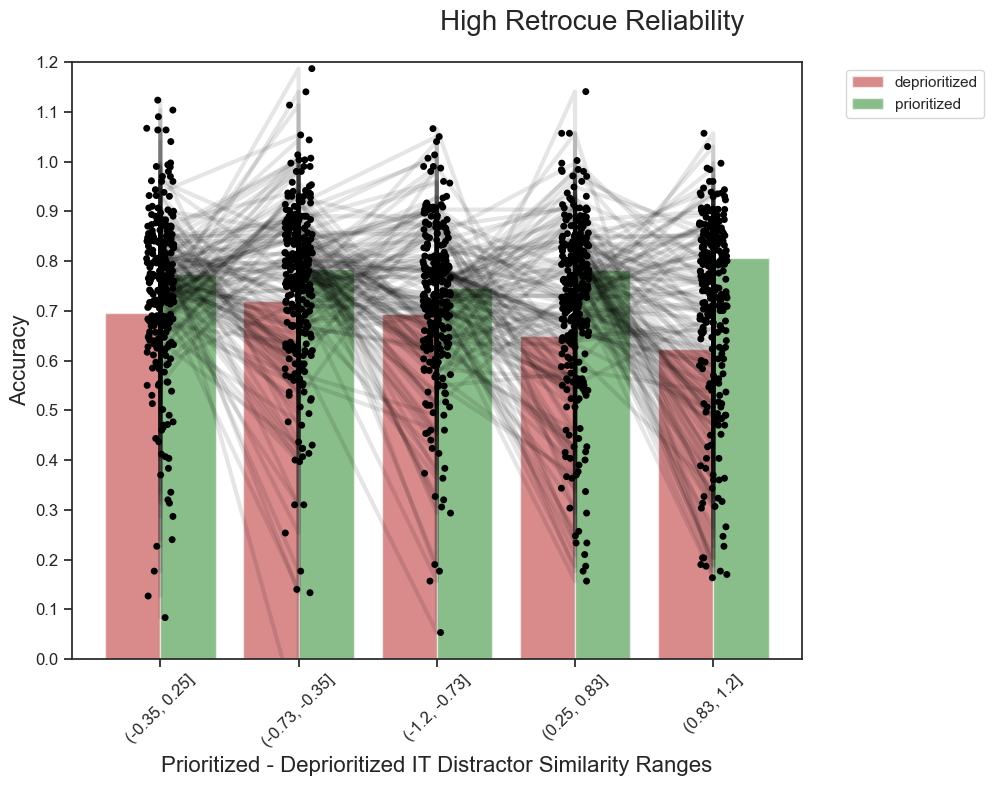

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/3223830374.py:20: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


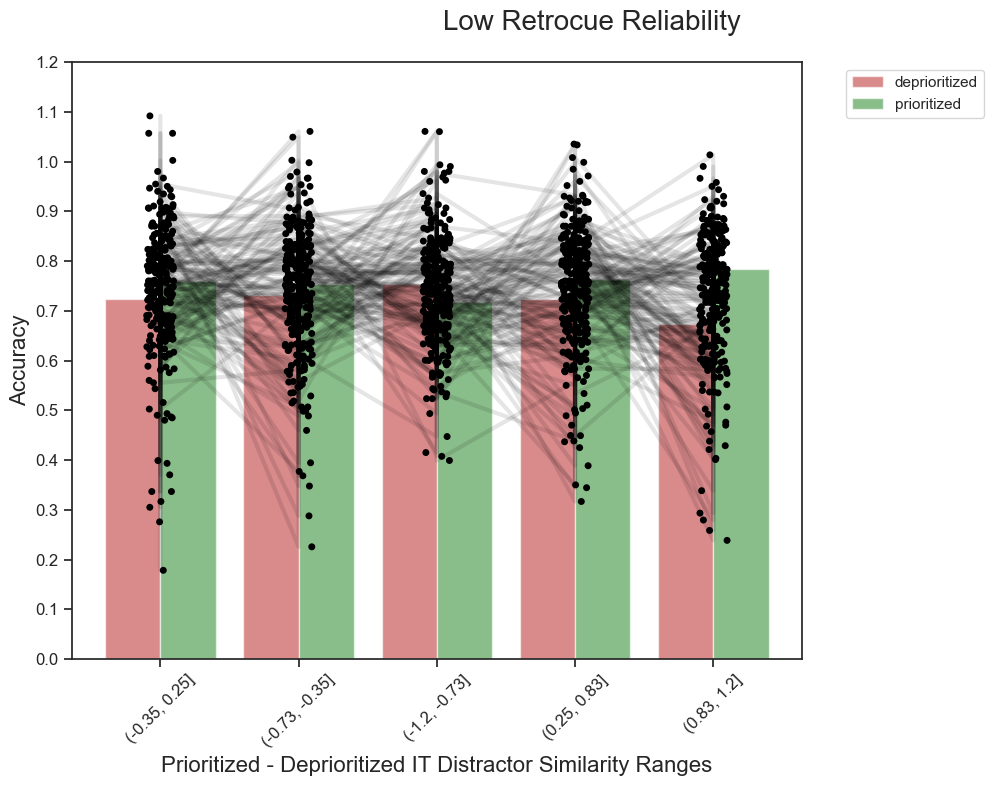

In [35]:


# Define color palette for Retrocue Reliability and Tested Item (Prioritized vs. Deprioritized)
palette_retrocue = {"high": "#1f77b4", "low": "#ff7f0e"}
palette_tested_item = {"prioritized": "#2ca02c", "deprioritized": "#d62728"}  # Colors for each Tested Item

# Split the data into two subsets based on Retrocue Reliability
df_high_retrocue = df[df['Retrocue Reliability'] == 'high']
df_low_retrocue = df[df['Retrocue Reliability'] == 'low']

# Function to create plot for each subset
def plot_retrocue_reliability(data, title, color_map):
    # Calculate subject-level and group means
    subject_means = data.groupby(['participant', 'Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item'])['Accuracy'].mean().reset_index()
    group_means = subject_means.groupby(['Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item'])['Accuracy'].mean().reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.set(style="ticks", rc={"lines.linewidth": 3})

    # Individual subject-level means with jitter
    sns.stripplot(
        x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
        y='Accuracy',
        data=subject_means,
        hue='Tested Item',
        palette=['black'],
        marker="o",
        jitter=True,
        s=5,
        zorder=10,
        ax=ax
    )

    # Mean accuracy across subjects in each group
    sns.barplot(
        x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
        y='Accuracy',
        hue='Tested Item',
        palette=color_map,  # Color based on Tested Item (Prioritized vs. Deprioritized)
        data=group_means,
        ax=ax,
        alpha=0.6
    )

    # Connection lines for individual subjects
    unique_subjects = subject_means['participant'].unique()
    for subject in unique_subjects:
        subset = subject_means[subject_means['participant'] == subject]
        if subset.shape[0] > 1:
            ax.plot(
                subset['Prioritized - Deprioritized IT Distractor Similarity Ranges'],
                subset['Accuracy'],
                color="black",
                alpha=0.1
            )

    # Customize appearance
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates by creating a dictionary
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.set_ylim(0, 1.2)  # Set y-axis height to 1.2
    ax.set_xlabel("Prioritized - Deprioritized IT Distractor Similarity Ranges", fontsize=16)
    ax.set_ylabel("Accuracy", fontsize=16)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    fig.suptitle(title, fontsize=20)
    fig.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Plot for high Retrocue Reliability with specific colors for "Prioritized" vs "Deprioritized"
plot_retrocue_reliability(df_high_retrocue, "High Retrocue Reliability", palette_tested_item)

# Plot for low Retrocue Reliability with specific colors for "Prioritized" vs "Deprioritized"
plot_retrocue_reliability(df_low_retrocue, "Low Retrocue Reliability", palette_tested_item)


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_94512/2386368627.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


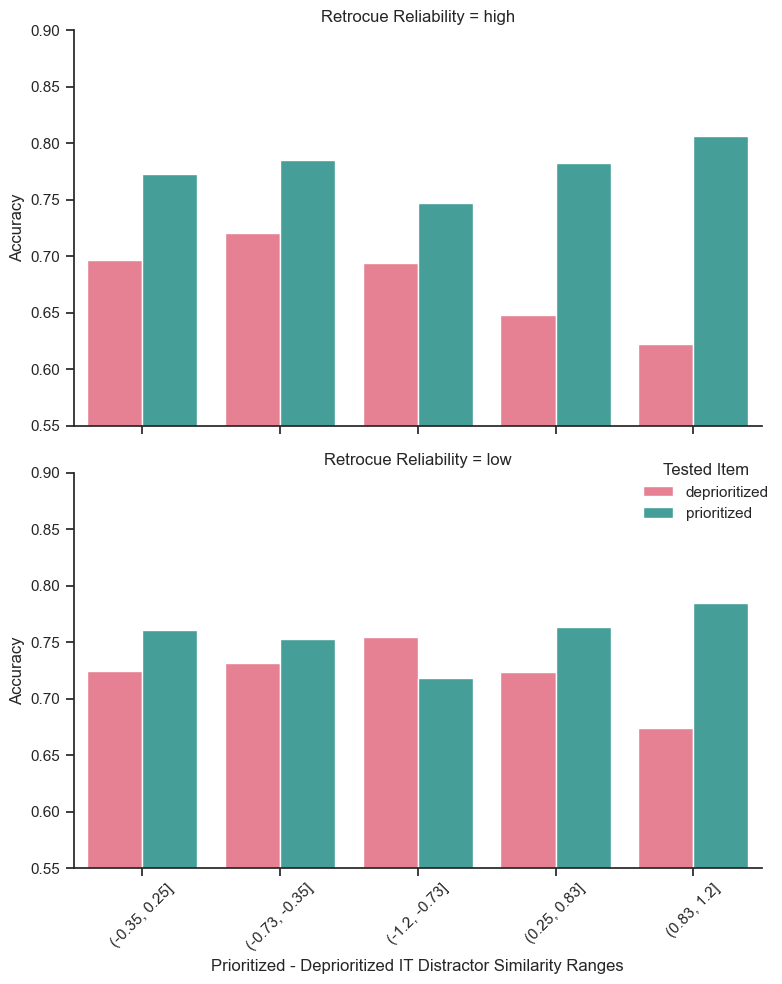

In [36]:

subject_means = df.groupby(['participant', 'Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item', 'Retrocue Reliability'])['Accuracy'].mean().reset_index()

# Step 2: Calculate the mean of these subject-level means for each condition
group_means = subject_means.groupby(['Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item', 'Retrocue Reliability'])['Accuracy'].mean().reset_index()

# Step 3: Plotting
# Create a bar plot with separate rows for high and low Retrocue Reliability, averaging across subject-level means
g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='Accuracy',
    hue='Tested Item',
    row='Retrocue Reliability',
    data=group_means,
    kind='bar',
    ci=68,            # Confidence interval
    dodge=True,       # Separate bars for each Tested Item
    aspect=1.3,
    palette=palette[::-1]
)

# Set the y-axis limit
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels for readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set axis labels
g.set_axis_labels("Prioritized - Deprioritized IT Distractor Similarity Ranges", "Accuracy")
plt.tight_layout()
plt.show()


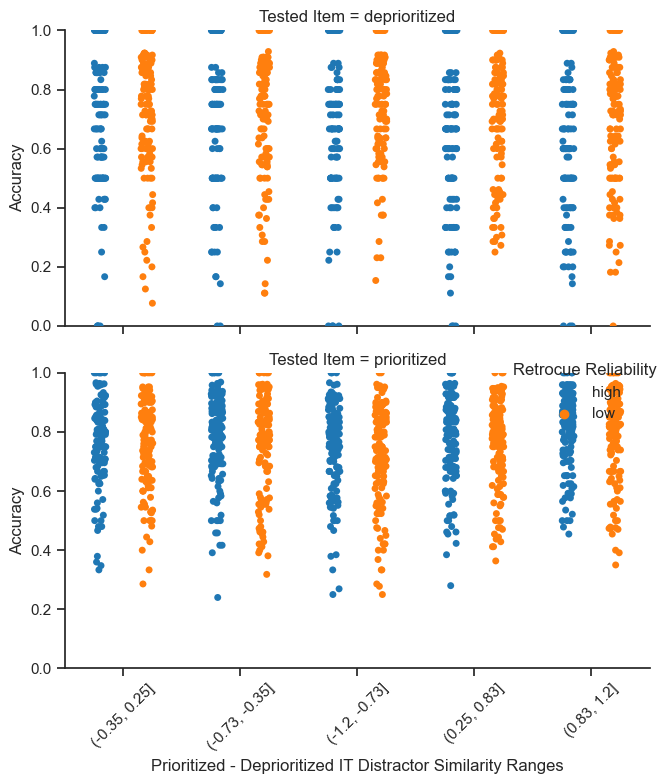

In [38]:
palette_retrocue = {"high": "#1f77b4", "low": "#ff7f0e"}  # Blue for high, Orange for low

# Create a FacetGrid to show separate rows for each level of Retrocue Reliability
g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='Accuracy',
    hue='Retrocue Reliability',
    row='Tested Item',  # Separate rows for high and low reliability
    data=subject_means,
    kind='strip',
    dodge=True,  # Jitter points side-by-side for different Tested Item values
    palette=palette_retrocue,  # Use color differences for Retrocue Reliability
    height=4,
    aspect=1.3
)

# Customize y-axis limit and axis labels
g.set(ylim=(0, 1))
g.set_axis_labels("Prioritized - Deprioritized IT Distractor Similarity Ranges", "Accuracy")

# Rotate x-axis labels for better readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

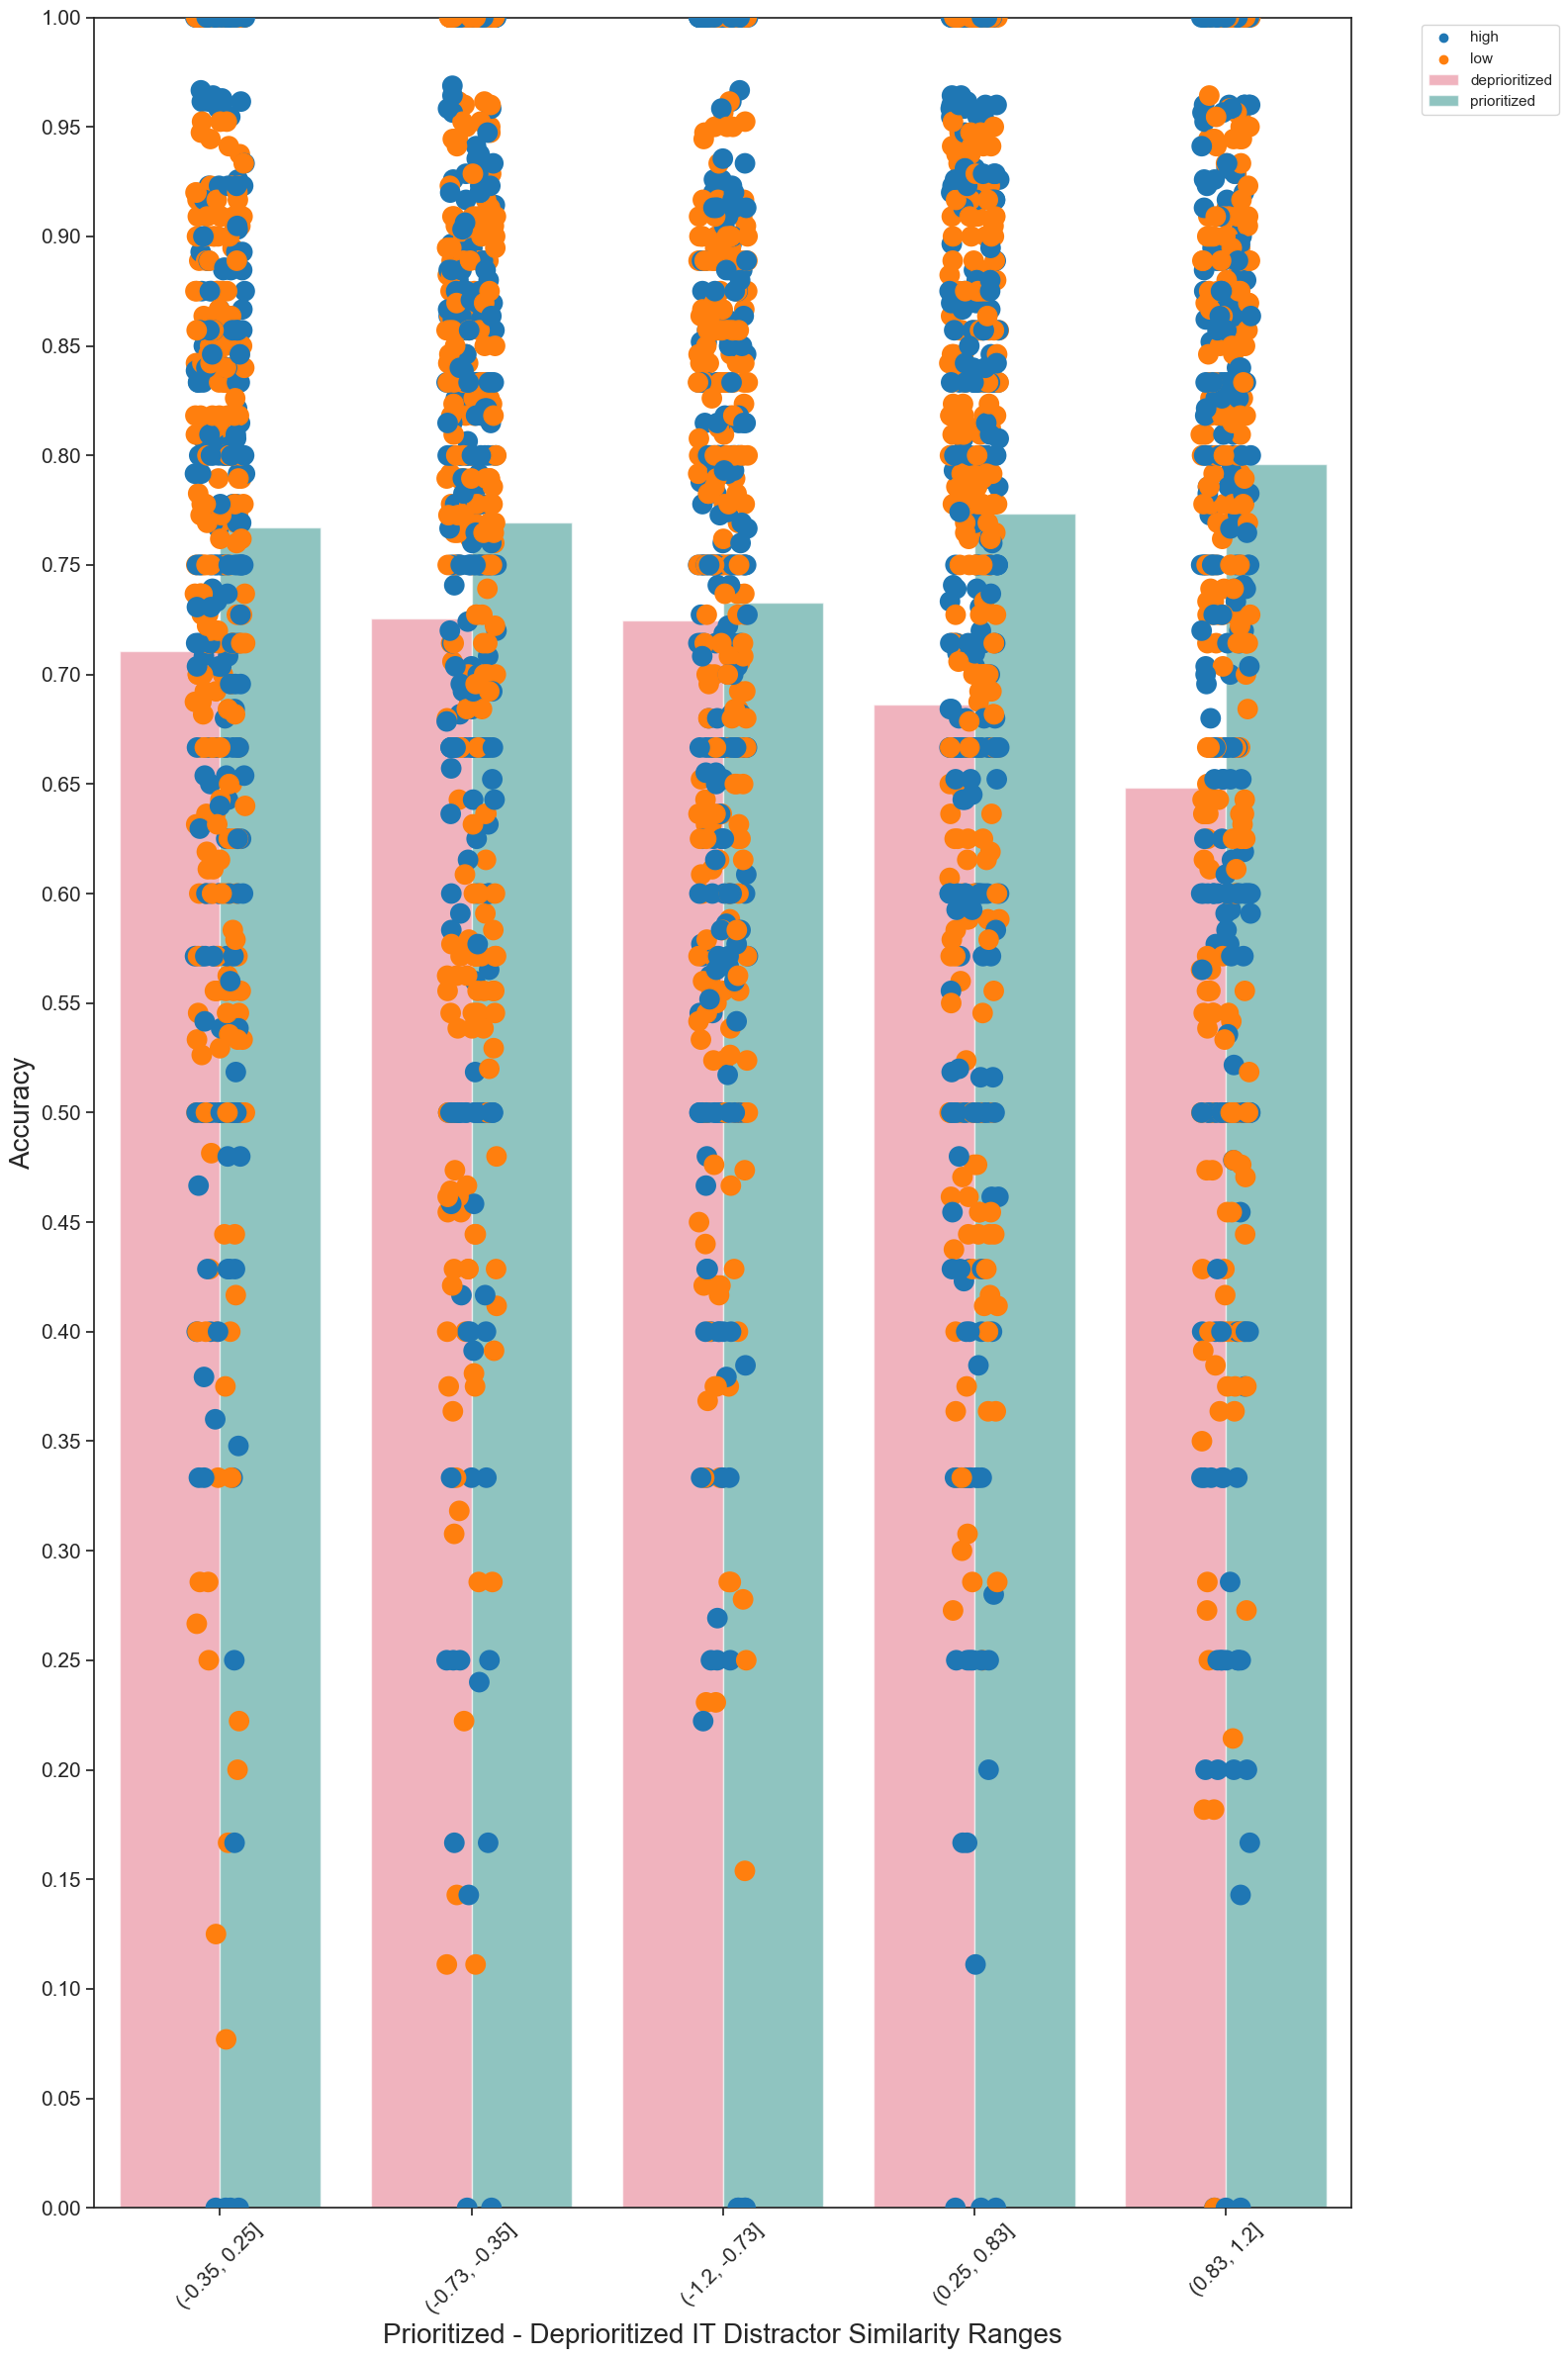

In [39]:
# Convert 'Prioritized - Deprioritized IT Distractor Similarity Ranges' to string for plotting
df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['Prioritized - Deprioritized IT Distractor Similarity Ranges'].astype(str)

# Preparing the subject-level mean data
subject_means = df.groupby(['participant', 'Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item', 'Retrocue Reliability'])['Accuracy'].mean().reset_index()
group_means = subject_means.groupby(['Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item'])['Accuracy'].mean().reset_index()

# Define a color palette for "Retrocue Reliability" (high and low)
# palette_retrocue = ["#1f77b4", "#ff7f0e"]  # Blue for high, Orange for low

# Plotting
fig, ax = plt.subplots(figsize=(16, 24))
sns.set(style="ticks", rc={"lines.linewidth": 3})

# Stripplot with "Retrocue Reliability" as hue to differentiate dots
sns.stripplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='Accuracy',
    data=subject_means,
    hue='Retrocue Reliability',  # Use Retrocue Reliability as hue
    palette=palette_retrocue,
    marker="o",
    jitter=True,
    s=15,
    zorder=10,
    ax=ax
)

# Overlay the bar plot for the mean accuracy across subjects in each group
sns.barplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='Accuracy',
    hue='Tested Item',
    palette=palette[::-1],
    data=group_means,
    ax=ax,
    alpha=0.6
)

# Clean up the legend to avoid duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Customize axis and plot appearance
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set_ylim(0, 1)
ax.set_xlabel("Prioritized - Deprioritized IT Distractor Similarity Ranges", fontsize=20)
ax.set_ylabel("Accuracy", fontsize=20)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.tick_params(axis='y', labelsize=15)

fig.tight_layout(rect=[0, 0, 1, 1])  # Adjust rect to create space for the legend
plt.show()


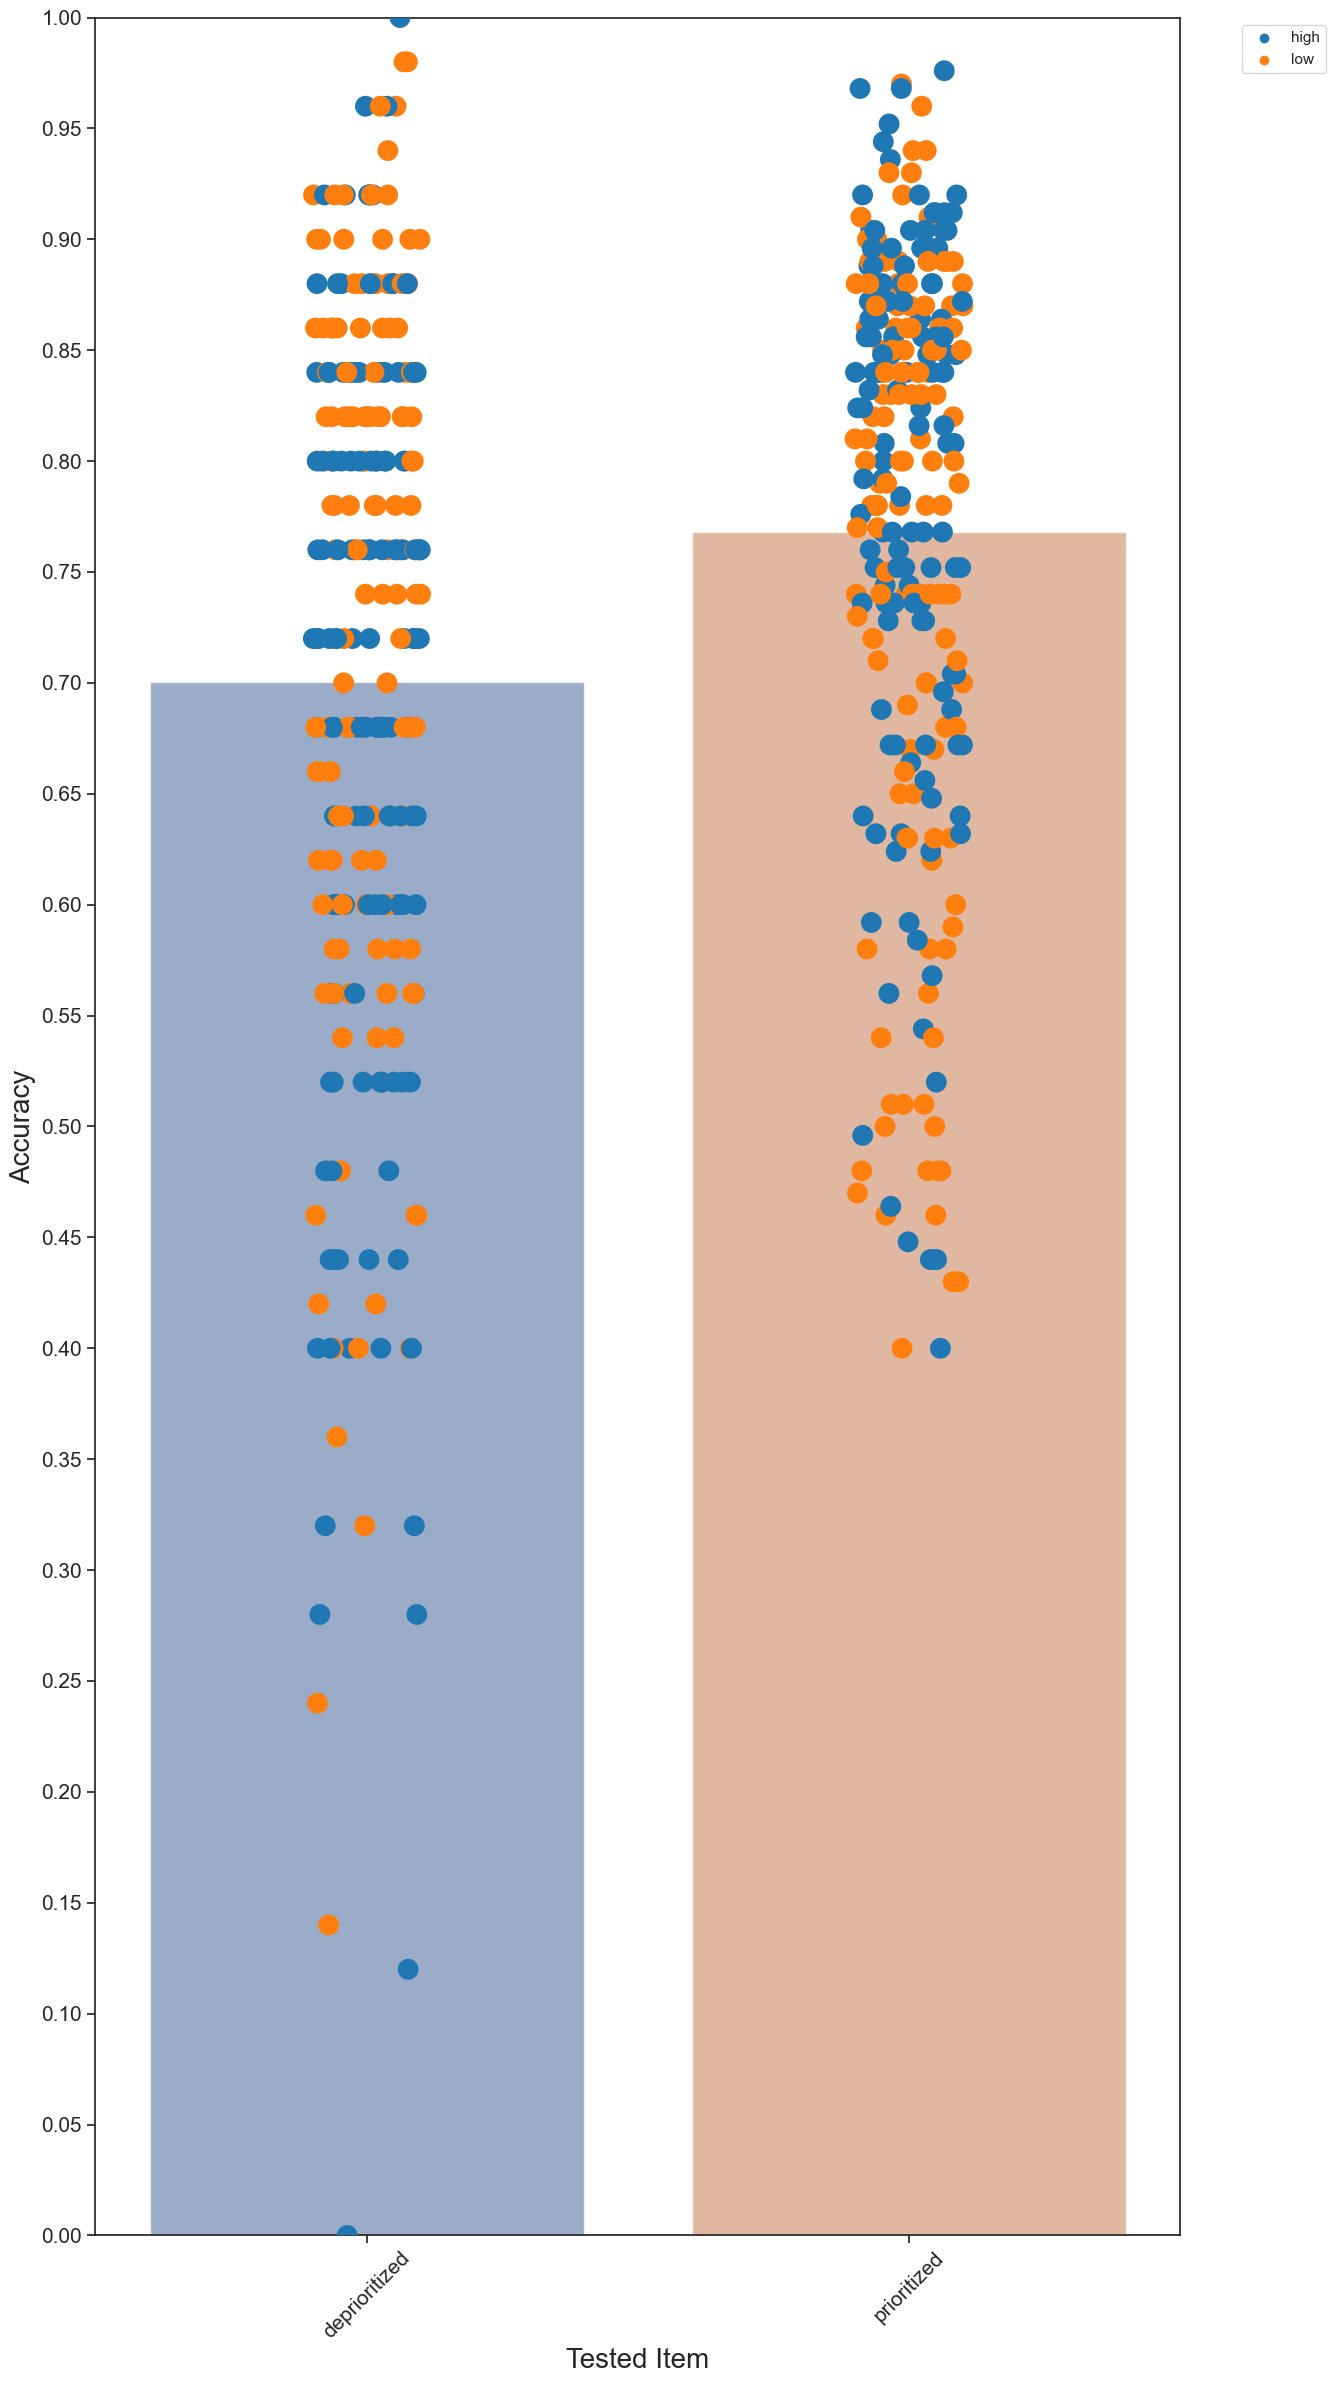

In [40]:
# Preparing the subject-level mean data without Prioritized - Deprioritized IT Distractor Similarity Ranges
subject_means = df.groupby(['participant', 'Tested Item', 'Retrocue Reliability'])['Accuracy'].mean().reset_index()
group_means = subject_means.groupby(['Tested Item'])['Accuracy'].mean().reset_index()

# Define a color palette for "Retrocue Reliability" (high and low) using blue and orange
palette_retrocue = ["#1f77b4", "#ff7f0e"]  # Blue for high, Orange for low

# Plotting
fig, ax = plt.subplots(figsize=(16, 24))
sns.set(style="ticks", rc={"lines.linewidth": 3})

# Stripplot with "Retrocue Reliability" as hue to differentiate dots
sns.stripplot(
    x='Tested Item',  # Changed x-axis to Tested Item
    y='Accuracy',
    data=subject_means,
    hue='Retrocue Reliability',  # Use Retrocue Reliability as hue
    palette=palette_retrocue,
    marker="o",
    jitter=True,
    s=15,
    zorder=10,
    ax=ax
)

# Overlay the bar plot for the mean accuracy across subjects in each group without hue
sns.barplot(
    x='Tested Item',  # Changed x-axis to Tested Item
    y='Accuracy',
    data=group_means,
    ax=ax,
#     color='gray'/,  # Single color for bar plot
    alpha=0.6
)

# Clean up the legend to avoid duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Customize axis and plot appearance
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set_ylim(0, 1)
ax.set_xlabel("Tested Item", fontsize=20)  # Updated x-axis label
ax.set_ylabel("Accuracy", fontsize=20)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.tick_params(axis='y', labelsize=15)

fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to create space for the legend
plt.show()
